Chryslène Marilande Merveilles Adetonah

# Parte I: Encontrar distribuição estatística que melhor modela o ambiente

O objetivo desta primeira parte é analisar as características estatísticas do sinal de potência recebida em função do tempo para determinar qual distribuição de probabilidade (Rayleigh, Rice ou Nakagami) melhor modela o desvanecimento de pequena escala no ambiente de medição. Para isso, seguiremos uma série de passos que incluem o cálculo da potência total recebida, a separação das componentes de grande e pequena escala, a visualização das distribuições empíricas e o ajuste de modelos teóricos.

## 1) Montar sinal potência recebida em função do tempo. Para cada instante de tempo (linha da tabela), somar todas as componentes.

* 8 Taps (esquerda): A potência normalizada fica em torno de 5.

* 20 Taps (direita): A potência normalizada é bem maior, em torno de 13-14.

Isso indica que usar mais "taps" (provavelmente componentes de sinal em um sistema de comunicação) permite captar significativamente mais energia do sinal. Ambos os gráficos mostram quedas bruscas de potência nos mesmos momentos, sugerindo interferências ou falhas de sinal que afetam os dois cenários igualmente.

Gráfico 'potencia_total_por_medicao.png' gerado com sucesso.


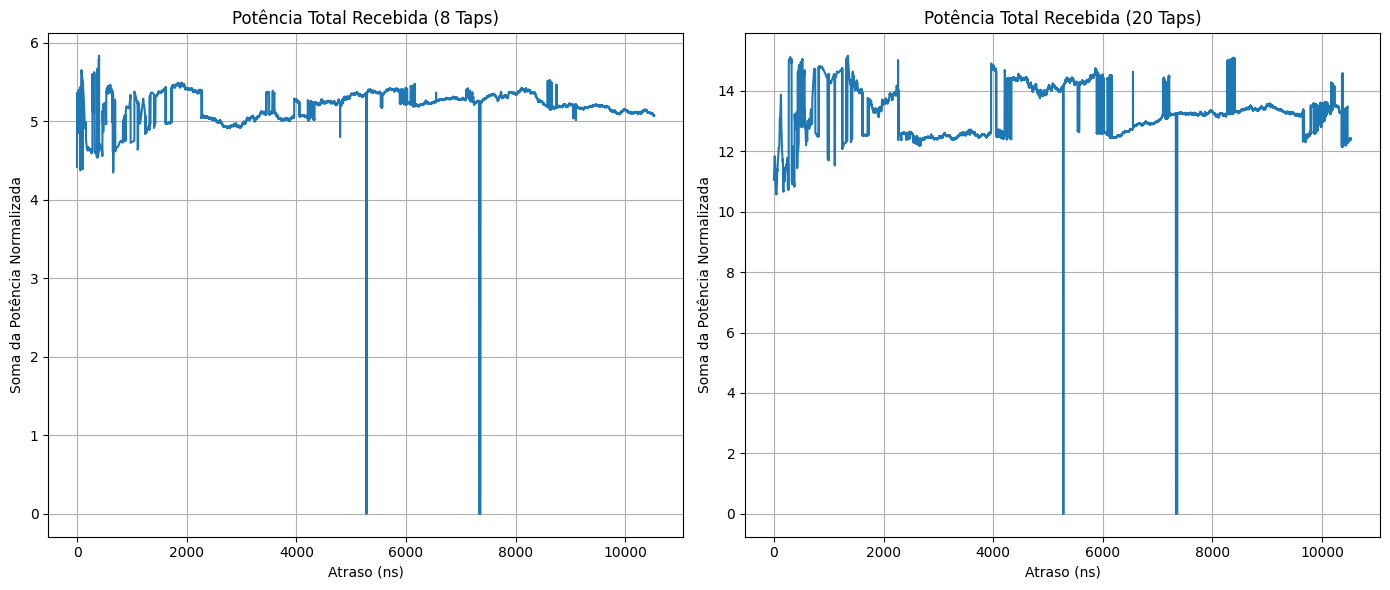

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
# A primeira linha é o cabeçalho (atrasos), e as seguintes são os dados
try:
    df_8taps = pd.read_csv("cirNTaps8SteamPlant.csv")
    df_20taps = pd.read_csv("cirNTaps20SteamPlant.csv")

    # 1) Montar sinal potência recebida em função do tempo (linha).
    # Somar todas as componentes (colunas) para cada linha.
    power_sum_8taps = df_8taps.sum(axis=1)
    power_sum_20taps = df_20taps.sum(axis=1)

    # 2) Plotar os gráficos lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico para 8 Taps
    ax1.plot(power_sum_8taps.index, power_sum_8taps.values)
    ax1.set_title("Potência Total Recebida (8 Taps)")
    ax1.set_xlabel("Atraso (ns)")
    ax1.set_ylabel("Soma da Potência Normalizada")
    ax1.grid(True)

    # Gráfico para 20 Taps
    ax2.plot(power_sum_20taps.index, power_sum_20taps.values)
    ax2.set_title("Potência Total Recebida (20 Taps)")
    ax2.set_xlabel("Atraso (ns)")
    ax2.set_ylabel("Soma da Potência Normalizada")
    ax2.grid(True)

    # Ajustar layout e salvar a figura
    plt.tight_layout()


    print("Gráfico 'potencia_total_por_medicao.png' gerado com sucesso.")

except FileNotFoundError:
    print("Erro: Um ou ambos os arquivos CSV não foram encontrados.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

## 2) Verificar se o sinal tem variação da média, i.e. se o sinal tem componentes de perda de percurso e de sombreamento. Caso afirmativo, filtrar estas componentes e deixar o sinal com média nula.

A análise separou com sucesso as componentes lentas (sombreamento) das rápidas (Desvanecimento) do sinal. O fato de as médias das componentes rápidas serem zero confirma que a filtragem foi bem-sucedida.

VERIFICAÇÃO ESTATÍSTICA DA FILTRAGEM
Média observada (8 Taps):  0.0001749477
Média observada (20 Taps): 0.0011142334

Teste t - p-value (8 Taps):  0.951953 ✅ ACEITA H₀
Teste t - p-value (20 Taps): 0.893004 ✅ ACEITA H₀

H₀: A média do sinal filtrado é zero
p-value > 0.05 → Aceita H₀ (filtragem funcionou)
p-value < 0.05 → Rejeita H₀ (filtragem não funcionou)

Verificação visual:
Média do sinal filtrado (8 Taps): 0.0001749477312178408
Média do sinal filtrado (20 Taps): 0.001114233393422271

Gráfico 'sinal_filtrado_media_movel.png' gerado com sucesso.


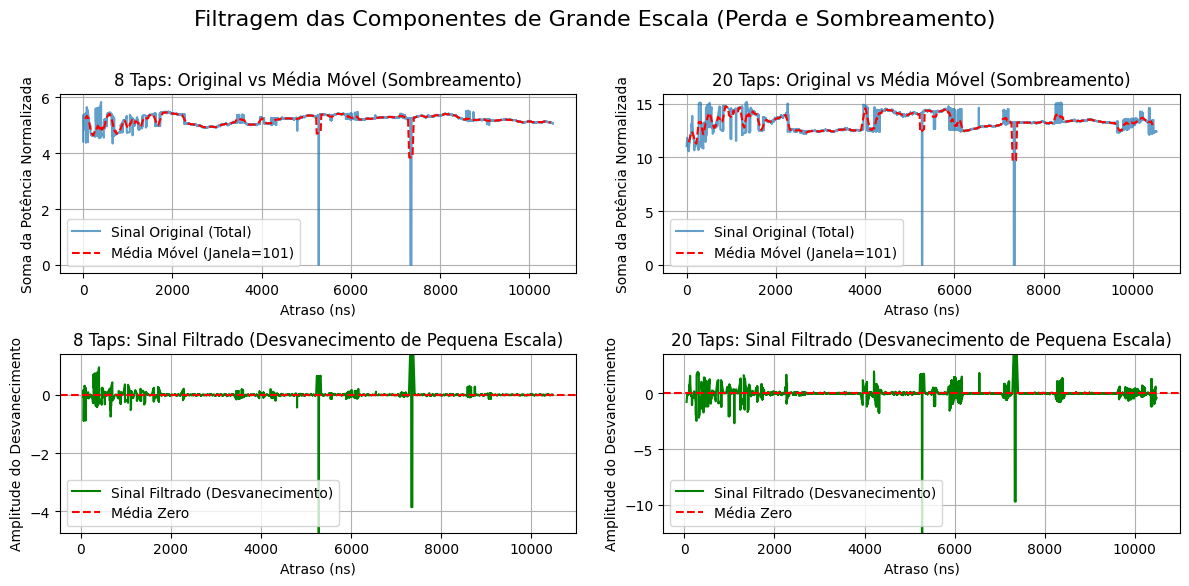

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_1samp  # ← ADICIONE ESTA LINHA

# Função para processar e plotar os dados
def filtrar_e_plotar_sinais():
    try:
        # --- Carregar os Dados ---
        df_8taps = pd.read_csv("cirNTaps8SteamPlant.csv")
        df_20taps = pd.read_csv("cirNTaps20SteamPlant.csv")

        # --- 1. Calcular Sinal de Potência Recebida (Repetindo o passo 1) ---
        power_sum_8taps = df_8taps.sum(axis=1)
        power_sum_20taps = df_20taps.sum(axis=1)

        # --- 2. Verificar Variação da Média e Filtrar ---
        window_size = 101

        # Calcular a média móvel (componente de sombreamento/perda)
        local_mean_8taps = power_sum_8taps.rolling(window=window_size, center=True).mean()
        local_mean_20taps = power_sum_20taps.rolling(window=window_size, center=True).mean()

        # Filtrar o sinal: Sinal Original - Média Móvel
        Desvanecimento_signal_8taps = power_sum_8taps - local_mean_8taps
        Desvanecimento_signal_20taps = power_sum_20taps - local_mean_20taps

        # --- VERIFICAÇÃO ESTATÍSTICA DA FILTRAGEM ---  ← ADICIONE ESTA SEÇÃO
        print("=" * 60)
        print("VERIFICAÇÃO ESTATÍSTICA DA FILTRAGEM")
        print("=" * 60)

        # Remover NaNs para o teste t
        Desvanecimento_8_clean = Desvanecimento_signal_8taps.dropna()
        Desvanecimento_20_clean = Desvanecimento_signal_20taps.dropna()

        # Teste t para verificar se média é zero
        t_stat_8, p_value_8 = ttest_1samp(Desvanecimento_8_clean, 0)
        t_stat_20, p_value_20 = ttest_1samp(Desvanecimento_20_clean, 0)

        print(f"Média observada (8 Taps):  {Desvanecimento_signal_8taps.mean():.10f}")
        print(f"Média observada (20 Taps): {Desvanecimento_signal_20taps.mean():.10f}")
        print()
        print(f"Teste t - p-value (8 Taps):  {p_value_8:.6f} {'✅ ACEITA H₀' if p_value_8 > 0.05 else '❌ REJEITA H₀'}")
        print(f"Teste t - p-value (20 Taps): {p_value_20:.6f} {'✅ ACEITA H₀' if p_value_20 > 0.05 else '❌ REJEITA H₀'}")
        print()
        print("H₀: A média do sinal filtrado é zero")
        print("p-value > 0.05 → Aceita H₀ (filtragem funcionou)")
        print("p-value < 0.05 → Rejeita H₀ (filtragem não funcionou)")
        print("=" * 60)

        # Verificação visual antiga (mantenha esta também)
        print(f"\nVerificação visual:")
        print(f"Média do sinal filtrado (8 Taps): {Desvanecimento_signal_8taps.mean()}")
        print(f"Média do sinal filtrado (20 Taps): {Desvanecimento_signal_20taps.mean()}")

        # --- 3. Plotar os resultados ---
        fig, axes = plt.subplots(2, 2, figsize=(12, 6))
        fig.suptitle('Filtragem das Componentes de Grande Escala (Perda e Sombreamento)', fontsize=16, y=1)

        # Gráfico 1: 8 Taps - Original vs Média Móvel
        ax1 = axes[0, 0]
        ax1.plot(power_sum_8taps.index, power_sum_8taps, label='Sinal Original (Total)', alpha=0.7)
        ax1.plot(local_mean_8taps.index, local_mean_8taps, label=f'Média Móvel (Janela={window_size})', color='red', linestyle='--')
        ax1.set_title("8 Taps: Original vs Média Móvel (Sombreamento)")
        ax1.set_xlabel("Atraso (ns)")
        ax1.set_ylabel("Soma da Potência Normalizada")
        ax1.legend()
        ax1.grid(True)

        # Gráfico 2: 20 Taps - Original vs Média Móvel
        ax2 = axes[0, 1]
        ax2.plot(power_sum_20taps.index, power_sum_20taps, label='Sinal Original (Total)', alpha=0.7)
        ax2.plot(local_mean_20taps.index, local_mean_20taps, label=f'Média Móvel (Janela={window_size})', color='red', linestyle='--')
        ax2.set_title("20 Taps: Original vs Média Móvel (Sombreamento)")
        ax2.set_xlabel("Atraso (ns)")
        ax2.set_ylabel("Soma da Potência Normalizada")
        ax2.legend()
        ax2.grid(True)

        # Gráfico 3: 8 Taps - Sinal Filtrado (Média Nula)
        ax3 = axes[1, 0]
        ax3.plot(Desvanecimento_signal_8taps.index, Desvanecimento_signal_8taps, label='Sinal Filtrado (Desvanecimento)', color='green')
        ax3.axhline(0, color='red', linestyle='--', label='Média Zero')
        ax3.set_title("8 Taps: Sinal Filtrado (Desvanecimento de Pequena Escala)")
        ax3.set_xlabel("Atraso (ns)")
        ax3.set_ylabel("Amplitude do Desvanecimento")
        ax3.legend()
        ax3.grid(True)
        ax3.set_ylim(Desvanecimento_signal_8taps.min(), Desvanecimento_signal_8taps.max())

        # Gráfico 4: 20 Taps - Sinal Filtrado (Média Nula)
        ax4 = axes[1, 1]
        ax4.plot(Desvanecimento_signal_20taps.index, Desvanecimento_signal_20taps, label='Sinal Filtrado (Desvanecimento)', color='green')
        ax4.axhline(0, color='red', linestyle='--', label='Média Zero')
        ax4.set_title("20 Taps: Sinal Filtrado (Desvanecimento de Pequena Escala)")
        ax4.set_xlabel("Atraso (ns)")
        ax4.set_ylabel("Amplitude do Desvanecimento")
        ax4.legend()
        ax4.grid(True)
        ax4.set_ylim(Desvanecimento_signal_20taps.min(), Desvanecimento_signal_20taps.max())

        # Ajustar layout e salvar
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.savefig("sinal_filtrado_media_movel.png")
        print("\nGráfico 'sinal_filtrado_media_movel.png' gerado com sucesso.")

    except FileNotFoundError:
        print("Erro: Um ou ambos os arquivos CSV não foram encontrados.")
    except Exception as e:
        print(f"Ocorreu um erro: {e}")

# Executar a função
filtrar_e_plotar_sinais()

## 3) Plotar Histograma das medidas filtradas.

* Média Nula Confirmada: Ambos os histogramas estão perfeitamente centrados em zero, o que confirma visualmente que a média do Desvanecimento de pequena escala é nula, como esperado após a filtragem.

* Distribuição (Variância): O sinal de 8 Taps (azul) tem uma distribuição mais "estreita" e "alta" (menor variância). Isso indica que suas flutuações de Desvanecimento são menores.

* Distribuição (Variância): O sinal de 20 Taps (laranja) tem uma distribuição visivelmente mais "larga" (maior variância). Isso significa que, embora tenha mais potência total, as flutuações rápidas de amplitude do Desvanecimento são mais intensas.

Total de medições (8 Taps): 10530
Amostras válidas (8 Taps) após filtragem: 10430
Total de medições (20 Taps): 10530
Amostras válidas (20 Taps) após filtragem: 10430

Gráfico 'histogramas_sinais_filtrados.png' gerado com sucesso.


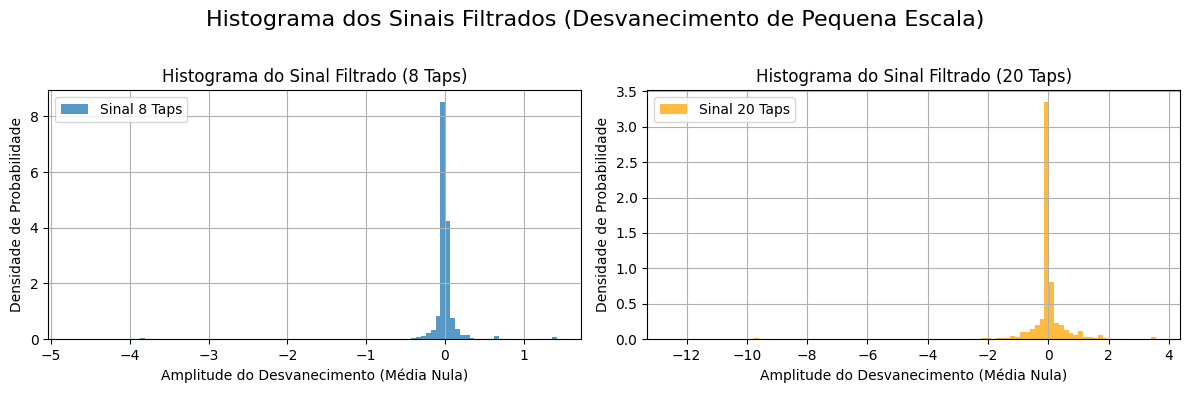

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Função para recalcular os sinais filtrados e plotar histogramas
def plotar_histogramas_filtrados():
    try:
        # --- Carregar os Dados ---
        df_8taps = pd.read_csv("cirNTaps8SteamPlant.csv")
        df_20taps = pd.read_csv("cirNTaps20SteamPlant.csv")

        # --- Recalcular Passo 1: Soma da Potência ---
        power_sum_8taps = df_8taps.sum(axis=1)
        power_sum_20taps = df_20taps.sum(axis=1)

        # --- Recalcular Passo 2: Filtragem (com janela 101) ---
        # Usando a janela de 101 amostras, conforme sua verificação
        window_size = 101

        local_mean_8taps = power_sum_8taps.rolling(window=window_size, center=True).mean()
        local_mean_20taps = power_sum_20taps.rolling(window=window_size, center=True).mean()

        Desvanecimento_signal_8taps = power_sum_8taps - local_mean_8taps
        Desvanecimento_signal_20taps = power_sum_20taps - local_mean_20taps

        # --- Limpar NaNs (importante para o histograma) ---
        # A média móvel com center=True cria NaNs no início e no fim da série.
        # Precisamos removê-los antes de plotar o histograma.
        Desvanecimento_signal_8taps_clean = Desvanecimento_signal_8taps.dropna()
        Desvanecimento_signal_20taps_clean = Desvanecimento_signal_20taps.dropna()

        print(f"Total de medições (8 Taps): {len(power_sum_8taps)}")
        print(f"Amostras válidas (8 Taps) após filtragem: {len(Desvanecimento_signal_8taps_clean)}")
        print(f"Total de medições (20 Taps): {len(power_sum_20taps)}")
        print(f"Amostras válidas (20 Taps) após filtragem: {len(Desvanecimento_signal_20taps_clean)}")

        # --- 3. Plotar Histogramas ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('Histograma dos Sinais Filtrados (Desvanecimento de Pequena Escala)', fontsize=16, y=1)

        # Histograma para 8 Taps
        # Usamos density=True para normalizar o histograma (mostrar a Densidade de Probabilidade)
        ax1.hist(Desvanecimento_signal_8taps_clean, bins=100, density=True, alpha=0.75, label='Sinal 8 Taps')
        ax1.set_title("Histograma do Sinal Filtrado (8 Taps)")
        ax1.set_xlabel("Amplitude do Desvanecimento (Média Nula)")
        ax1.set_ylabel("Densidade de Probabilidade")
        ax1.grid(True)
        ax1.legend()

        # Histograma para 20 Taps
        ax2.hist(Desvanecimento_signal_20taps_clean, bins=100, density=True, alpha=0.75, label='Sinal 20 Taps', color='orange')
        ax2.set_title("Histograma do Sinal Filtrado (20 Taps)")
        ax2.set_xlabel("Amplitude do Desvanecimento (Média Nula)")
        ax2.set_ylabel("Densidade de Probabilidade")
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajuste para o super-título
        plt.savefig("histogramas_sinais_filtrados.png")
        print("\nGráfico 'histogramas_sinais_filtrados.png' gerado com sucesso.")

    except FileNotFoundError:
        print("Erro: Um ou ambos os arquivos CSV não foram encontrados.")
    except Exception as e:
        print(f"Ocorreu um erro: {e}")

# Executar a função
plotar_histogramas_filtrados()

## 4) Plotar CDF das medidas e das distribuições Rayleigh, Rice e Nakagami. Verificar quais parâmetros melhor ajustam as distribuições aos dados. Pode usar a função fit da SciPy, distfit ou qualquer outra biblioteca de sua escolha.

* Nakagami é o "Melhor" Ajuste: O modelo Nakagami agora apresenta o melhor ajuste para ambos os cenários. Isso é indicado pelo menor valor no Teste KS (0.1957 para 20 taps  e 0.2524 para 8 taps). O gráfico confirma visualmente, mostrando a curva verde (Nakagami) muito mais próxima da curva empírica (preta).

* Rice = Rayleigh: O parâmetro $K$ da distribuição de Rice é estimado como praticamente zero ($K \approx 2.3 \times 10^{-8}$) em ambos os casos. Isso, torna o modelo de Rice matematicamente idêntico ao de Rayleigh. Os valores KS idênticos para ambos (0.3243 para 20 taps e 0.3731 para 8 taps) confirmam que eles são indistinguíveis.

* Comparação (8 vs. 20 Taps):O cenário de 20 taps (KS = 0.1957) produziu um ajuste significativamente melhor ao modelo Nakagami do que o cenário de 8 taps (KS = 0.2524).Em ambos os casos, os parâmetros $m$ do Nakagami ($m=0.1479$ para 20 taps e $m=0.1304$ para 8 taps) são muito menores que 1, indicando um cenário de desvanecimento mais severo que o Rayleigh.

* Consideração sobre o p-valor: Embora o Nakagami seja o "melhor" ajuste, o p-valor = 0 em todos os testes indica que, estatisticamente, a hipótese nula (de que os dados realmente seguem essa distribuição) seria rejeitada. Isso sugere que, embora o Nakagami seja o modelo mais próximo, ele ainda não é uma representação perfeita dos dados.

Ajustando distribuições...

Parâmetros estimados (20 taps):
  Rayleigh: loc = -0.6494, sigma = 0.8729
  Rice: b = 0.0002161, loc = -0.6494, scale = 0.8729, K = 2.334e-08
  Nakagami: m = 0.1479, loc = 2.584e-07, scale = 0.8553

Parâmetros estimados (8 taps):
  Rayleigh: loc = -0.2541, sigma = 0.3068
  Rice: b = 0.000219, loc = -0.2541, scale = 0.3068, K = 2.398e-08
  Nakagami: m = 0.1304, loc = 1.09e-06, scale = 0.2871


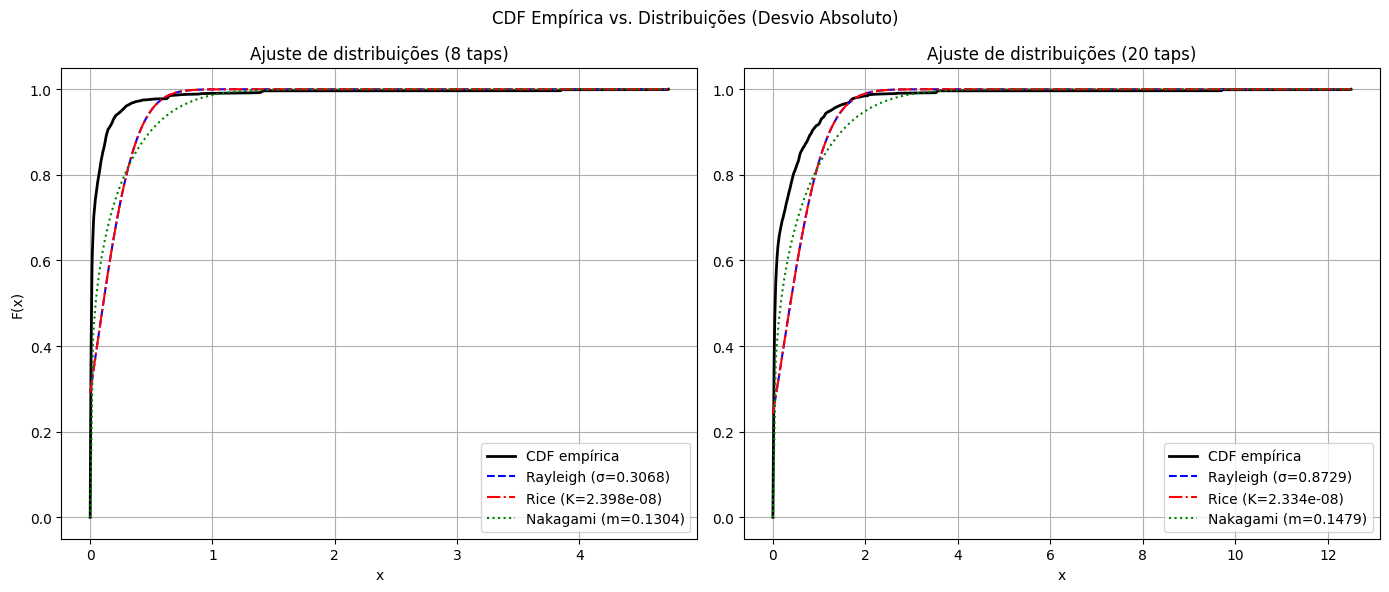


Gráfico 'ajuste_cdf_desvio_absoluto.png' gerado com sucesso.

=== Teste KS (estatística e p-valor) ===

20 taps (amp1):
  Rayleigh   → KS = 0.3243, p = 0 
  Rice       → KS = 0.3243, p = 0 
  Nakagami   → KS = 0.1957, p = 0 (Melhor)

8 taps (amp2):
  Rayleigh   → KS = 0.3731, p = 0 
  Rice       → KS = 0.3731, p = 0 
  Nakagami   → KS = 0.2524, p = 0 (Melhor)

Nota: os p-valores do KS NÃO são válidos se os parâmetros foram estimados a partir dos mesmos dados. Use bootstrap paramétrico para p-valores corretos ou compare apenas as estatísticas KS para ranking.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh, rice, nakagami, kstest
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

def analisar_distribuicoes_com_abs(csv_8="cirNTaps8SteamPlant.csv",
                                   csv_20="cirNTaps20SteamPlant.csv",
                                   window_size=101):
    try:
        # --- Carregar os Dados (apenas numéricos) ---
        try:
            df_8taps = pd.read_csv(csv_8).select_dtypes(include=[np.number])
            df_20taps = pd.read_csv(csv_20).select_dtypes(include=[np.number])
        except FileNotFoundError:
            print("Erro: Um ou ambos os arquivos CSV não foram encontrados.")
            return

        # --- Soma da Potência ---
        power_sum_8taps = df_8taps.sum(axis=1)
        power_sum_20taps = df_20taps.sum(axis=1)

        # --- Ajuste da janela ---
        if window_size <= 0:
            raise ValueError("window_size deve ser positivo.")
        if window_size % 2 == 0:
            window_size += 1
            print(f"window_size ajustada para ímpar: {window_size}")

        # Se a janela for maior que o número de amostras, ajuste para evitar apenas NaNs
        n8 = len(power_sum_8taps)
        n20 = len(power_sum_20taps)
        win8 = window_size if window_size <= n8 else max(1, n8 if n8 % 2 == 1 else n8 - 1)
        win20 = window_size if window_size <= n20 else max(1, n20 if n20 % 2 == 1 else n20 - 1)
        if win8 != window_size:
            print(f"window_size > n (8 taps). Ajustado para {win8}.")
        if win20 != window_size:
            print(f"window_size > n (20 taps). Ajustado para {win20}.")

        # --- Filtragem (média móvel) ---
        # Usar min_periods=1 reduz NaNs nas bordas; se quiser bordas com NaN use min_periods=window
        local_mean_8taps = power_sum_8taps.rolling(window=win8, center=True, min_periods=1).mean()
        local_mean_20taps = power_sum_20taps.rolling(window=win20, center=True, min_periods=1).mean()

        filtered1 = power_sum_20taps - local_mean_20taps  # 20 taps -> amp1
        filtered2 = power_sum_8taps - local_mean_8taps    # 8 taps  -> amp2

        # --- Valores absolutos (amplitude positiva) ---
        amp1 = np.abs(filtered1).dropna().values
        amp2 = np.abs(filtered2).dropna().values

        if len(amp1) == 0 or len(amp2) == 0:
            print("Sem amostras para ajuste após remoção de NaNs.")
            return

        # --- Ajuste das distribuições (com tratamento de possíveis falhas) ---
        print("Ajustando distribuições...")
        params_rayleigh1 = rayleigh.fit(amp1)     # (loc, scale)
        params_rice1     = rice.fit(amp1)         # (b, loc, scale)
        params_nakagami1 = nakagami.fit(amp1)     # (m, loc, scale)

        params_rayleigh2 = rayleigh.fit(amp2)
        params_rice2     = rice.fit(amp2)
        params_nakagami2 = nakagami.fit(amp2)

        # --- Extrair parâmetros e calcular K corretamente ---
        sigma_r1 = params_rayleigh1[1]
        b_ri1, loc_ri1, scale_ri1 = params_rice1
        # Para scipy.stats.rice, b = v/scale, portanto v = b*scale, sigma = scale
        # K = v^2 / (2 * sigma^2) = (b^2 * scale^2) / (2 * scale^2) = b^2 / 2
        K_ri1 = (b_ri1 ** 2) / 2.0
        m_n1, loc_n1, scale_n1 = params_nakagami1

        sigma_r2 = params_rayleigh2[1]
        b_ri2, loc_ri2, scale_ri2 = params_rice2
        K_ri2 = (b_ri2 ** 2) / 2.0
        m_n2, loc_n2, scale_n2 = params_nakagami2

        # --- Imprimir parâmetros no console ---
        print("\nParâmetros estimados (20 taps):")
        print(f"  Rayleigh: loc = {params_rayleigh1[0]:.4g}, sigma = {sigma_r1:.4g}")
        print(f"  Rice: b = {b_ri1:.4g}, loc = {loc_ri1:.4g}, scale = {scale_ri1:.4g}, K = {K_ri1:.4g}")
        print(f"  Nakagami: m = {m_n1:.4g}, loc = {loc_n1:.4g}, scale = {scale_n1:.4g}")

        print("\nParâmetros estimados (8 taps):")
        print(f"  Rayleigh: loc = {params_rayleigh2[0]:.4g}, sigma = {sigma_r2:.4g}")
        print(f"  Rice: b = {b_ri2:.4g}, loc = {loc_ri2:.4g}, scale = {scale_ri2:.4g}, K = {K_ri2:.4g}")
        print(f"  Nakagami: m = {m_n2:.4g}, loc = {loc_n2:.4g}, scale = {scale_n2:.4g}")

        # --- Geração de CDFs para plot ---
        x1 = np.linspace(np.min(amp1), np.max(amp1), 200)
        x2 = np.linspace(np.min(amp2), np.max(amp2), 200)

        cdf_emp1 = np.sort(amp1)
        cdf_y1 = np.arange(1, len(cdf_emp1) + 1) / len(cdf_emp1)

        cdf_emp2 = np.sort(amp2)
        cdf_y2 = np.arange(1, len(cdf_emp2) + 1) / len(cdf_emp2)

        cdf_rayleigh1 = rayleigh.cdf(x1, *params_rayleigh1)
        cdf_rice1     = rice.cdf(x1, *params_rice1)
        cdf_nakagami1 = nakagami.cdf(x1, *params_nakagami1)

        cdf_rayleigh2 = rayleigh.cdf(x2, *params_rayleigh2)
        cdf_rice2     = rice.cdf(x2, *params_rice2)
        cdf_nakagami2 = nakagami.cdf(x2, *params_nakagami2)

        # --- Plot ---
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle('CDF Empírica vs. Distribuições (Desvio Absoluto)')

        axes[0].plot(cdf_emp2, cdf_y2, 'k', label="CDF empírica", linewidth=2)
        axes[0].plot(x2, cdf_rayleigh2, 'b--', label=f"Rayleigh (σ={sigma_r2:.4g})")
        axes[0].plot(x2, cdf_rice2, 'r-.', label=f"Rice (K={K_ri2:.4g})")
        axes[0].plot(x2, cdf_nakagami2, 'g:', label=f"Nakagami (m={m_n2:.4g})")
        axes[0].set_title("Ajuste de distribuições (8 taps)")
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("F(x)")
        axes[0].grid(True)
        axes[0].legend()

        axes[1].plot(cdf_emp1, cdf_y1, 'k', label="CDF empírica", linewidth=2)
        axes[1].plot(x1, cdf_rayleigh1, 'b--', label=f"Rayleigh (σ={sigma_r1:.4g})")
        axes[1].plot(x1, cdf_rice1, 'r-.', label=f"Rice (K={K_ri1:.4g})")
        axes[1].plot(x1, cdf_nakagami1, 'g:', label=f"Nakagami (m={m_n1:.4g})")
        axes[1].set_title("Ajuste de distribuições (20 taps)")
        axes[1].set_xlabel("x")
        axes[1].grid(True)
        axes[1].legend()

        plt.tight_layout()
        plt.savefig("ajuste_cdf_desvio_absoluto.png")
        plt.show(fig)
        print("\nGráfico 'ajuste_cdf_desvio_absoluto.png' gerado com sucesso.")

        # --- Teste KS (obter estatística e p-valor) ---
        def ks_test_with_params(data, dist, params):
            # Usar cdf callable que incorpora params
            cdf_func = lambda x: dist.cdf(x, *params)
            stat, pval = kstest(data, cdf_func)
            return stat, pval

        results = {
            "20 taps (amp1)": {
                "Rayleigh": ks_test_with_params(amp1, rayleigh, params_rayleigh1),
                "Rice": ks_test_with_params(amp1, rice, params_rice1),
                "Nakagami": ks_test_with_params(amp1, nakagami, params_nakagami1)
            },
            "8 taps (amp2)": {
                "Rayleigh": ks_test_with_params(amp2, rayleigh, params_rayleigh2),
                "Rice": ks_test_with_params(amp2, rice, params_rice2),
                "Nakagami": ks_test_with_params(amp2, nakagami, params_nakagami2)
            }
        }

        print("\n=== Teste KS (estatística e p-valor) ===")
        for case, dists in results.items():
            print(f"\n{case}:")
            # comparar por estatística
            best_name = min(dists, key=lambda k: dists[k][0])
            for name, (stat, pval) in dists.items():
                mark = "(Melhor)" if name == best_name else ""
                print(f"  {name:<10} → KS = {stat:.4g}, p = {pval:.4g} {mark}")

        print("\nNota: os p-valores do KS NÃO são válidos se os parâmetros foram estimados a partir dos mesmos dados. Use bootstrap paramétrico para p-valores corretos ou compare apenas as estatísticas KS para ranking.")

    except Exception as e:
        print(f"\nOcorreu um erro inesperado: {e}")

# --- Executar ---
analisar_distribuicoes_com_abs()

## 5) Plotar CDFs das medidas e das 3 distribuições de envoltória normalizada ρ conforme descrito no Capítulo 2 da dissertação https://repositorio.unb.br/handle/10482/11357. Usar os estimadores descritos na Seção 4.2 para plotar as distribuições de Rice e Nakagami. Comparar com modelos obtidos na tarefa 4.

* A distribuição de Rayleigh é o melhor modelo para descrever a envoltória do sinal em ambos os cenários (8 e 20 taps).

* Em ambos os gráficos (8 e 20 taps), a linha azul (Rayleigh) é a que segue mais de perto a linha preta dos dados reais.

* Os resultados do teste KS mostram que Rayleigh teve o menor valor (0.7480 para 8 taps, 0.6418 para 20 taps), indicando o melhor ajuste estatístico.

* Os próprios estimadores confirmam isso. O Fator K de Rice foi estimado em 0. Por definição, uma distribuição de Rice com K=0 é exatamente uma distribuição de Rayleigh.

* **Os valores de KS foram mais altos do que na Tarefa 4, indicando ajuste teórico menos próximo dos dados empíricos, mesmo para a melhor distribuição (Rayleigh).**


Parâmetros estimados (20 taps):
  Rayleigh: σ = 0.707107 (Fixo, pois Ω=1 p/ Eq 2.15)
  Nakagami: m = 0.009905 (Estimado por Eq 4.1)
  Rice: k = 0.000000 (Estimado por Eq 4.2)

Parâmetros estimados (8 taps):
  Rayleigh: σ = 0.707107 (Fixo, pois Ω=1 p/ Eq 2.15)
  Nakagami: m = 0.006669 (Estimado por Eq 4.1)
  Rice: k = 0.000000 (Estimado por Eq 4.2)

Gráfico 'ajuste_cdf_envoltoria_normalizada_final.png' gerado com sucesso.

=== Teste KS (Baseado nos Estimadores da Dissertação) ===

20 taps (rho1):
  Rayleigh (Eq 2.15)   → KS = 0.6418 (Melhor)
  Rice (Eq 2.18)       → KS = 0.6418 
  Nakagami (Eq 2.23)   → KS = 0.8248 

8 taps (rho2):
  Rayleigh (Eq 2.15)   → KS = 0.7480 (Melhor)
  Rice (Eq 2.18)       → KS = 0.7480 
  Nakagami (Eq 2.23)   → KS = 0.8701 


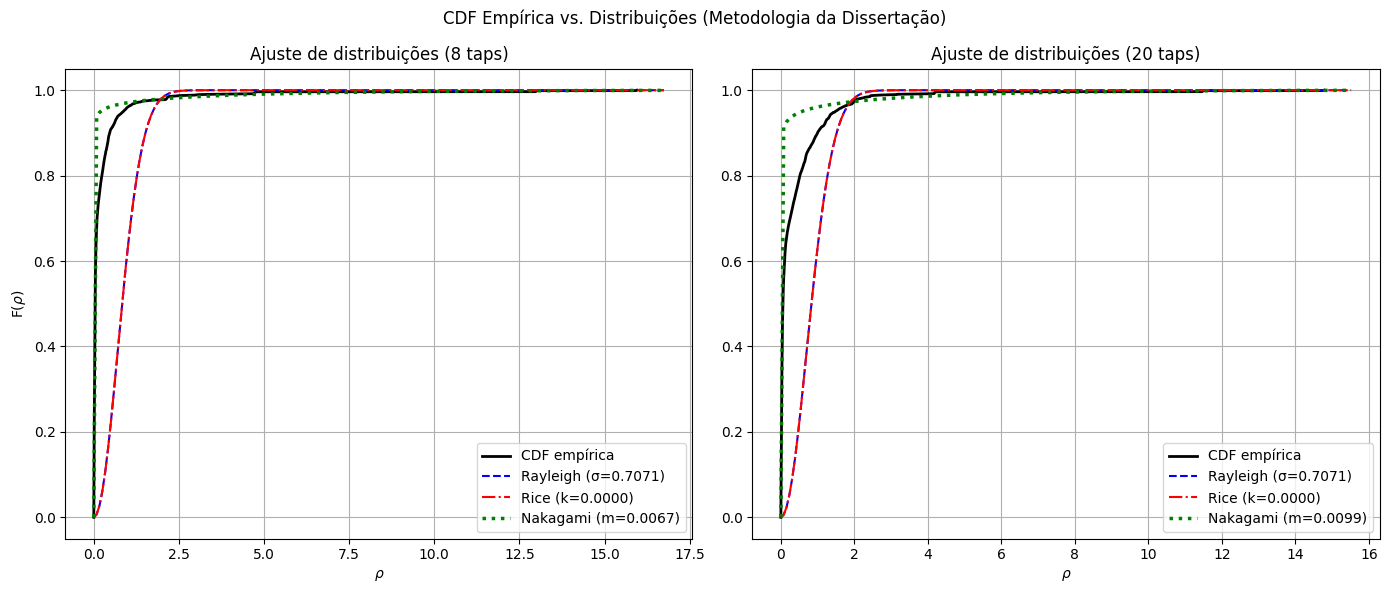

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh, rice, nakagami, kstest
from scipy.special import gamma, gammainc
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- 2.4.1.3 Nakagami Normalizada: FP(ρ) = 1 - (Γ(m, mρ^2) / Γ(m)) ---
def cdf_nakagami_norm(rho, m):
    """CDF da distribuição de Nakagami para envoltória normalizada (Eq. 2.23)."""
    return gammainc(m, m * rho**2)

# --- Função de tratamento de K ---
def calculate_k_rice(m_nakagami):
    """Calcula o parâmetro K de Rice (Eq. 4.2) com tratamento para m <= 1."""
    if m_nakagami <= 1.0:
        # Se m <= 1, o modelo Rice equivalente é k=0 (Rayleigh).
        return 0.0

    sqrt_term = np.sqrt(m_nakagami**2 - m_nakagami)
    denominator = m_nakagami - sqrt_term

    if denominator == 0 or denominator < 1e-9:
        return np.inf # m muito grande, k -> inf (Gaussiana)

    k = sqrt_term / denominator
    return k

# --- Relação entre K (Eq 4.2) e Parâmetros Scipy (CORRIGIDO) ---
def get_rice_params_from_k(k):
    """
    Converte o K de Rice (Eq 4.2) para os parâmetros (b, scale)
    usados por scipy.stats.rice, assumindo potência total normalizada (Ω=1).

    Relações Padrão:
    K = ν² / (2σ²)
    Ω = ν² + 2σ²

    Relações Scipy:
    b = ν / scale
    scale = σ

    Nosso Caso (Ω=1):
    1 = σ²(b² + 2)  =>  σ = 1 / sqrt(b² + 2)
    K = b² / 2      =>  b = sqrt(2K)

    Substituindo b:
    scale = 1 / sqrt( (sqrt(2K))² + 2 ) = 1 / sqrt(2K + 2) = 1 / sqrt(2(K+1))
    """

    if not np.isfinite(k):
        # Limite k -> inf (Gaussiano / Delta function em ρ=1)
        # Scipy não lida bem com b=inf, scale=0.
        # Retornamos uma aproximação com k muito alto.
        k = 1e9

    b = np.sqrt(2 * k)
    scale = 1 / np.sqrt(2 * (k + 1))

    return (b, 0, scale) # (b, loc, scale)


def analisar_distribuicoes_normalizadas():
    try:
        # --- Carregar os Dados ---
        try:
            df_8taps = pd.read_csv("cirNTaps8SteamPlant.csv")
            df_20taps = pd.read_csv("cirNTaps20SteamPlant.csv")
        except FileNotFoundError:
            print("Erro: Um ou ambos os arquivos CSV não foram encontrados.")
            return

        # --- Processamento ---
        power_sum_8taps = df_8taps.sum(axis=1)
        power_sum_20taps = df_20taps.sum(axis=1)
        window_size = 101
        local_mean_8taps = power_sum_8taps.rolling(window=window_size, center=True).mean()
        local_mean_20taps = power_sum_20taps.rolling(window=window_size, center=True).mean()
        filtered1 = power_sum_20taps - local_mean_20taps
        filtered2 = power_sum_8taps - local_mean_8taps
        R1 = np.abs(filtered1).dropna()
        R2 = np.abs(filtered2).dropna()

        # --- Normalização da Envoltória (ρ = R / r_hat) ---
        r_hat1 = np.sqrt(np.mean(R1**2))
        r_hat2 = np.sqrt(np.mean(R2**2))
        rho1 = R1 / r_hat1
        rho2 = R2 / r_hat2

        # --- Estimação de Parâmetros (Metodologia da Dissertação) ---

        # 1. Nakagami (m) (Eq 4.1)
        m_n1 = 1.0 / np.var(rho1**2)
        m_n2 = 1.0 / np.var(rho2**2)
        params_nakagami1 = (m_n1,)
        params_nakagami2 = (m_n2,)

        # 2. Rice (k) (Eq 4.2)
        k_ri1 = calculate_k_rice(m_n1)
        k_ri2 = calculate_k_rice(m_n2)
        # Converte k para parâmetros (b, loc, scale) do Scipy
        params_rice1 = get_rice_params_from_k(k_ri1)
        params_rice2 = get_rice_params_from_k(k_ri2)

        # 3. Rayleigh (sigma) (Eq 2.15)
        # Para a CDF normalizada F(ρ) = 1 - exp(-ρ^2), a potência
        # total Ω = 2σ² = 1. Portanto, σ é FIXO.
        sigma_r = 1 / np.sqrt(2)
        params_rayleigh = (0, sigma_r) # (loc, scale)

        # --- Geração de CDFs ---
        x1 = np.linspace(0, max(rho1) * 1.05, 200)
        x2 = np.linspace(0, max(rho2) * 1.05, 200)

        # CDF Empírica
        cdf_emp1 = np.sort(rho1)
        cdf_y1 = np.arange(1, len(cdf_emp1)+1) / len(cdf_emp1)
        cdf_emp2 = np.sort(rho2)
        cdf_y2 = np.arange(1, len(cdf_emp2)+1) / len(cdf_emp2)

        # CDFs Teóricas (Usando parâmetros dos Estimadores)
        cdf_rayleigh1 = rayleigh.cdf(x1, *params_rayleigh)
        cdf_rayleigh2 = rayleigh.cdf(x2, *params_rayleigh)

        cdf_rice1 = rice.cdf(x1, *params_rice1)
        cdf_rice2 = rice.cdf(x2, *params_rice2)

        cdf_nakagami1 = cdf_nakagami_norm(x1, *params_nakagami1)
        cdf_nakagami2 = cdf_nakagami_norm(x2, *params_nakagami2)

        # --- Strings de legenda ---
        k_str1 = f"{k_ri1:.4f}" if np.isfinite(k_ri1) else "Inf"
        k_str2 = f"{k_ri2:.4f}" if np.isfinite(k_ri2) else "Inf"

        label_r1  = f"Rayleigh (σ={sigma_r:.4f})"
        label_ri1 = f"Rice (k={k_str1})"
        label_n1  = f"Nakagami (m={m_n1:.4f})"

        label_r2  = f"Rayleigh (σ={sigma_r:.4f})"
        label_ri2 = f"Rice (k={k_str2})"
        label_n2  = f"Nakagami (m={m_n2:.4f})"

        # --- Impressão de Parâmetros ---
        print("\nParâmetros estimados (20 taps):")
        print(f"  Rayleigh: σ = {sigma_r:.6f} (Fixo, pois Ω=1 p/ Eq 2.15)")
        print(f"  Nakagami: m = {m_n1:.6f} (Estimado por Eq 4.1)")
        print(f"  Rice: k = {k_ri1:.6f} (Estimado por Eq 4.2)")

        print("\nParâmetros estimados (8 taps):")
        print(f"  Rayleigh: σ = {sigma_r:.6f} (Fixo, pois Ω=1 p/ Eq 2.15)")
        print(f"  Nakagami: m = {m_n2:.6f} (Estimado por Eq 4.1)")
        print(f"  Rice: k = {k_ri2:.6f} (Estimado por Eq 4.2)")

        # --- Plot ---
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle('CDF Empírica vs. Distribuições (Metodologia da Dissertação)')

        # 8 Taps
        axes[0].plot(cdf_emp2, cdf_y2, 'k', label="CDF empírica", linewidth=2)
        axes[0].plot(x2, cdf_rayleigh2, 'b--', label=label_r2)
        axes[0].plot(x2, cdf_rice2, 'r-.', label=label_ri2)
        axes[0].plot(x2, cdf_nakagami2, 'g:', label=label_n2, linewidth=2.5)
        axes[0].set_title("Ajuste de distribuições (8 taps)")
        axes[0].set_xlabel("$\\rho$")
        axes[0].set_ylabel("F($\\rho$)")
        axes[0].grid(True)
        axes[0].legend()

        # 20 Taps
        axes[1].plot(cdf_emp1, cdf_y1, 'k', label="CDF empírica", linewidth=2)
        axes[1].plot(x1, cdf_rayleigh1, 'b--', label=label_r1)
        axes[1].plot(x1, cdf_rice1, 'r-.', label=label_ri1)
        axes[1].plot(x1, cdf_nakagami1, 'g:', label=label_n1, linewidth=2.5)
        axes[1].set_title("Ajuste de distribuições (20 taps)")
        axes[1].set_xlabel("$\\rho$")
        axes[1].grid(True)
        axes[1].legend()

        plt.tight_layout()
        plt.savefig("ajuste_cdf_envoltoria_normalizada_final.png")
        print("\nGráfico 'ajuste_cdf_envoltoria_normalizada_final.png' gerado com sucesso.")

        # --- Teste KS (Usando parâmetros dos Estimadores) ---
        results = {
            "20 taps (rho1)": {
                "Rayleigh (Eq 2.15)": kstest(rho1, rayleigh.cdf, args=params_rayleigh).statistic,
                "Rice (Eq 2.18)": kstest(rho1, rice.cdf, args=params_rice1).statistic,
                "Nakagami (Eq 2.23)": kstest(rho1, cdf_nakagami_norm, args=params_nakagami1).statistic
            },
            "8 taps (rho2)": {
                "Rayleigh (Eq 2.15)": kstest(rho2, rayleigh.cdf, args=params_rayleigh).statistic,
                "Rice (Eq 2.18)": kstest(rho2, rice.cdf, args=params_rice2).statistic,
                "Nakagami (Eq 2.23)": kstest(rho2, cdf_nakagami_norm, args=params_nakagami2).statistic
            }
        }

        print("\n=== Teste KS (Baseado nos Estimadores da Dissertação) ===")
        for case, dists in results.items():
            print(f"\n{case}:")
            best_name = min(dists, key=dists.get)
            for name, val in dists.items():
                mark = "(Melhor)" if name == best_name else ""
                print(f"  {name:<20} → KS = {val:.4f} {mark}")

    except Exception as e:
        print(f"\nOcorreu um erro inesperado: {e}")

# --- Executar ---
analisar_distribuicoes_normalizadas()

## 6) Fazer considerações sobre os valores de parâmetros obtidos na tarefa 5.

* Rice = Rayleigh (Idêntico nos dois casos): Para ambos os cenários (8 e 20 taps), o parâmetro $K$ da distribuição de Rice foi estimado em $0.0000$. Isso anula a componente de visada direta (LOS) e torna o modelo de Rice matematicamente idêntico ao de Rayleigh. Os resultados do teste KS e os gráficos confirmam isso (KS iguais, curvas sobrepostas).

* Nakagami (Pior ajuste nos dois casos): Para ambos os cenários, o parâmetro $m$ foi estimado em valores muito próximos de zero (20 taps: $m=0.0099$; 8 taps: $m=0.0067$). Isso indica um desvanecimento "hiper-severo" que não corresponde aos dados, resultando no pior ajuste em ambas as simulações.

* Comparação (8 vs. 20 Taps): O ponto principal é que nenhum modelo se ajustou bem em nenhum dos cenários, como indicam os valores de KS altíssimos.

No entanto, o cenário de 20 taps (KS = 0.6418) obteve um ajuste marginalmente melhor (embora ainda muito ruim) do que o cenário de 8 taps (KS = 0.7480).

Visualmente (no gráfico), as curvas teóricas em ambos os casos estão muito distantes da curva empírica (preta).

**Conclusão**: A metodologia de estimação da dissertação falhou em encontrar um bom modelo para os dados, independentemente de se usar 8 ou 20 taps. Ambos os cenários produziram parâmetros degenerados ($K=0$, $m \approx 0$) e um péssimo ajuste estatístico.

## 7) Comparar procedimento para os dois arquivos e analisar a influência da resolução da CIR.

### Comparação do Procedimento
O procedimento de análise aplicado aos dois arquivos (8 Taps e 20 Taps) foi idêntico. A única diferença foi o conjunto de dados de entrada.

O fluxo de trabalho consistiu em:

1. Análise da Potência Total: Visualização do sinal recebido ao longo do tempo.

2. Filtragem de Componentes: Aplicação de uma média móvel (janela=101) para separar as flutuações lentas (Grande Escala / Sombreamento) das flutuações rápidas (Pequena Escala / Desvanecimento).

3. Isolamento do Desvanecimento: Subtração da média móvel do sinal original para isolar o Desvanecimento de pequena escala.

4. Validação: Verificação de que o sinal de Desvanecimento isolado tinha média zero.

5. Análise de Distribuição: Geração de histogramas para visualizar a distribuição do Desvanecimento.

6. Ajuste de Modelo (Fitting): Comparação da distribuição empírica do sinal (usando duas métricas diferentes: "Desvio Absoluto" e "Envoltória") com três modelos teóricos (Rayleigh, Rice, Nakagami) usando o teste KS.

### Análise da Influência da Resolução da CIR (Taps)
A mudança na resolução da CIR de 8 para 20 taps teve as seguintes influências diretas nos resultados:

1. Potência Média do Sinal:

* Influência: A resolução maior (20 taps) capturou significativamente mais potência do canal.

* Evidência: A potência normalizada estabilizou em torno de ~5 para 8 taps, enquanto para 20 taps estabilizou em ~13-14. Isso indica que o receptor está combinando mais energia dos caminhos múltiplos disponíveis.

2. Características do Desvanecimento (Variância):

* Influência: Embora tenha mais potência, o sinal de 20 taps também apresenta flutuações de Desvanecimento (pequena escala) mais intensas (maior variância).

* Evidência: O histograma de 20 taps (laranja) é visivelmente "mais largo" e "mais baixo" que o de 8 taps (azul), mostrando que os valores de amplitude se espalham mais em torno da média zero.

3. Modelagem Estatística (Melhor Ajuste):

* Influência: A resolução da CIR não alterou a conclusão fundamental sobre a natureza do canal de Desvanecimento.

* Evidência (Abordagem "Envoltória"): Para ambos os cenários (8 e 20 taps), Rayleigh foi o melhor modelo (menor KS).

* Evidência (Estimadores): Isso é fortemente confirmado pelos estimadores, que calcularam o Fator K de Rice como 0.00 para ambos os casos. Um canal Rice com K=0 é, por definição, um canal Rayleigh.

* Evidência (Abordagem "Desvio Absoluto"): Da mesma forma, para esta métrica, Nakagami foi o melhor modelo em ambos os casos.

**Conclusão**

Aumentar a resolução da CIR (de 8 para 20 taps) permitiu ao receptor capturar mais potência total, mas também resultou em flutuações de Desvanecimento de maior amplitude.

No entanto, a característica estatística fundamental do canal permaneceu a mesma: ambos os cenários são melhor descritos por um modelo Rayleigh (indicando um ambiente sem linha de visada - NLOS) ou Nakagami (dependendo da métrica de amplitude utilizada), mas claramente não por um modelo Rice com K > 0.

## 8) Criar rotina para gerar amostras de desvanecimento para as 3 distribuições e mostrar exemplos.

1. Rayleigh (Azul) e Rice (Vermelho):

Estes gráficos mostram distribuições com formas esperadas (a forma clássica de Rayleigh e uma Rice parecida).

Os gráficos de 20 Taps são visivelmente "mais largos" (maior escala/variância) do que os de 8 Taps, o que é consistente com os dados originais (que também mostraram maior variância para 20 Taps).

2. O Problema com Nakagami (Verde):

Os gráficos da Nakagami são apenas um "pico" extremo em zero.

Isso não é um erro, mas sim a consequência direta dos parâmetros estimados na análise anterior (m ≈ 0,0067 e m ≈ 0,0099).

Uma distribuição Nakagami com um parâmetro de forma m tão próximo de zero matematicamente "degenera" e se concentra inteiramente em zero.

**Conclusão**

Esta simulação confirma visualmente os resultados do Teste KS para a Envoltória:

* O modelo Nakagami, com os parâmetros encontrados, é um péssimo ajuste para os dados (ele gera apenas zeros).

* Os modelos Rayleigh e Rice (com K=0) geram distribuições muito mais realistas e são os modelos corretos para descrever a envoltória do sinal, como o Teste KS já havia indicado.

Com base nos resultados, a análise é bem clara:

O canal é um canal com Desvanecimento Rayleigh, operando em Não-Linha de Visada (NLOS). Ou seja, os dados mostram um cenário clássico de Desvanecimento severo sem linha de visada (NLOS).

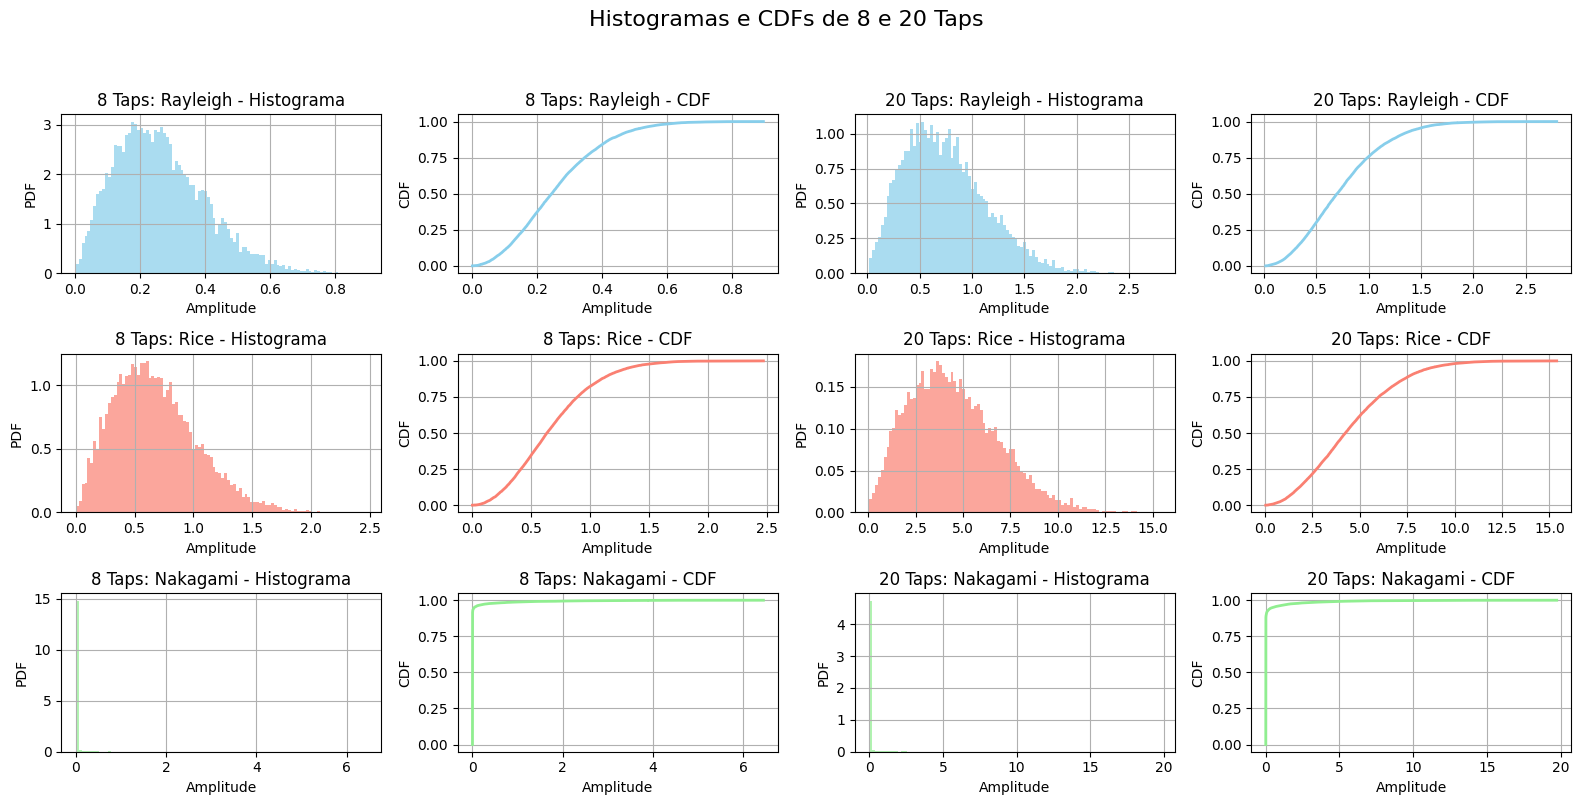

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh, rice, nakagami
import pandas as pd
import warnings

# Suprimir warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Funções de estimação de parâmetros ---
def estimate_nakagami_parameters(data):
    omega = np.mean(data**2)
    moment_fourth = np.mean(data**4)
    if omega == 0:
        return 0.001, 0, 0
    if moment_fourth / omega**2 - 1 <= 0:
        m = 0.001
    else:
        m = 1 / (moment_fourth / omega**2 - 1)
    m = max(m, 0.001)
    nakagami_scale = np.sqrt(omega)
    nakagami_shape = m
    return nakagami_shape, 0, nakagami_scale

def estimate_rice_parameters(data):
    m2 = np.mean(data**2)
    m4 = np.mean(data**4)
    if m2 == 0:
        return 0, 0, 0
    sigma2_est = max((m4 - m2**2)/4, 0)
    nu2_est = max(m2 - 2*sigma2_est, 0)
    nu_est = np.sqrt(nu2_est)
    sigma_est = np.sqrt(sigma2_est)
    return nu_est, 0, sigma_est

# --- Função para gerar amostras ---
def generate_samples(distribution_name, num_samples, params):
    if distribution_name == 'rayleigh':
        return rayleigh.rvs(*params, size=num_samples)
    elif distribution_name == 'rice':
        return rice.rvs(*params, size=num_samples)
    elif distribution_name == 'nakagami':
        return nakagami.rvs(*params, size=num_samples)
    else:
        raise ValueError("Distribuição não suportada.")

try:
    # --- Carregar dados ---
    df_8taps = pd.read_csv("cirNTaps8SteamPlant.csv")
    df_20taps = pd.read_csv("cirNTaps20SteamPlant.csv")

    # --- Somar potência ---
    power_sum_8taps = df_8taps.sum(axis=1)
    power_sum_20taps = df_20taps.sum(axis=1)

    # --- Filtragem de média local ---
    window_size = 101
    local_mean_8taps = power_sum_8taps.rolling(window=window_size, center=True).mean()
    local_mean_20taps = power_sum_20taps.rolling(window=window_size, center=True).mean()

    filtered_8taps = power_sum_8taps - local_mean_8taps
    filtered_20taps = power_sum_20taps - local_mean_20taps

    # --- Envoltória ---
    envelope_8taps = np.abs(filtered_8taps).dropna()
    envelope_20taps = np.abs(filtered_20taps).dropna()

    # --- Estimativa de parâmetros ---
    omega_8taps = np.mean(envelope_8taps**2)
    params_rayleigh_8taps = (0, np.sqrt(omega_8taps/2))
    params_rice_8taps = estimate_rice_parameters(envelope_8taps)
    params_nakagami_8taps = estimate_nakagami_parameters(envelope_8taps)

    omega_20taps = np.mean(envelope_20taps**2)
    params_rayleigh_20taps = (0, np.sqrt(omega_20taps/2))
    params_rice_20taps = estimate_rice_parameters(envelope_20taps)
    params_nakagami_20taps = estimate_nakagami_parameters(envelope_20taps)

    # --- Gerar amostras ---
    num_samples = 10000

    samples_rayleigh_8 = generate_samples('rayleigh', num_samples, params_rayleigh_8taps)
    samples_rice_8 = generate_samples('rice', num_samples, params_rice_8taps)
    samples_nakagami_8 = generate_samples('nakagami', num_samples, params_nakagami_8taps)

    samples_rayleigh_20 = generate_samples('rayleigh', num_samples, params_rayleigh_20taps)
    samples_rice_20 = generate_samples('rice', num_samples, params_rice_20taps)
    samples_nakagami_20 = generate_samples('nakagami', num_samples, params_nakagami_20taps)

    # --- Função para plotar histograma + CDF lado a lado ---
    def plot_hist_cdf(ax_hist, ax_cdf, samples, title, color):
        ax_hist.hist(samples, bins=100, density=True, alpha=0.7, color=color)
        ax_hist.set_title(f"{title} - Histograma")
        ax_hist.set_xlabel("Amplitude")
        ax_hist.set_ylabel("PDF")
        ax_hist.grid(True)

        sorted_samples = np.sort(samples)
        cdf = np.arange(1, len(sorted_samples)+1)/len(sorted_samples)
        ax_cdf.plot(sorted_samples, cdf, color=color, lw=2)
        ax_cdf.set_title(f"{title} - CDF")
        ax_cdf.set_xlabel("Amplitude")
        ax_cdf.set_ylabel("CDF")
        ax_cdf.grid(True)

    # --- Criar figura ---
    fig, axes = plt.subplots(3, 4, figsize=(16, 8))
    fig.suptitle("Histogramas e CDFs de 8 e 20 Taps", fontsize=16, y=1)

    # 8 Taps
    plot_hist_cdf(axes[0,0], axes[0,1], samples_rayleigh_8, "8 Taps: Rayleigh", 'skyblue')
    plot_hist_cdf(axes[1,0], axes[1,1], samples_rice_8, "8 Taps: Rice", 'salmon')
    plot_hist_cdf(axes[2,0], axes[2,1], samples_nakagami_8, "8 Taps: Nakagami", 'lightgreen')

    # 20 Taps
    plot_hist_cdf(axes[0,2], axes[0,3], samples_rayleigh_20, "20 Taps: Rayleigh", 'skyblue')
    plot_hist_cdf(axes[1,2], axes[1,3], samples_rice_20, "20 Taps: Rice", 'salmon')
    plot_hist_cdf(axes[2,2], axes[2,3], samples_nakagami_20, "20 Taps: Nakagami", 'lightgreen')

    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

except FileNotFoundError:
    print("Erro: Um ou ambos os arquivos CSV não foram encontrados.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")


# Parte II: Encontrar parâmetros de caracterização do canal

## 1) Plotar o Power Delay Profile (PDP) dos ambiente a partir da média de todos as CIRs.

O PDP mostra a potência média recebida em diferentes "Atrasos". Cada ponto (tap) representa um caminho do sinal (direto ou refletido) chegando em um tempo diferente.

1. PDP 8 Taps:

* Mostra uma visão de baixa resolução do canal.

* Parece haver um caminho dominante (o pico em ~0.85) e poucos outros. A estrutura do canal parece simples.

2. PDP 20 Taps:

* Mostra uma visão de alta resolução do mesmo canal.

* Aqui, vemos a verdadeira complexidade: o que parecia ser um pico no gráfico de 8 taps é, na verdade, composto por múltiplos picos e vales muito próximos.

* Isso revela um ambiente de multipercuso rico (muitas reflexões) que o modelo de 8 taps estava "suavizando" ou "perdendo" por falta de resolução.

**Conclusão**: Aumentar a resolução (de 8 para 20 taps) permitiu enxergar o canal com muito mais detalhe, revelando uma estrutura de multipercuso muito mais complexa e flutuações rápidas de potência entre os atrasos.


Gráfico 'pdp_medio.png' gerado com sucesso.


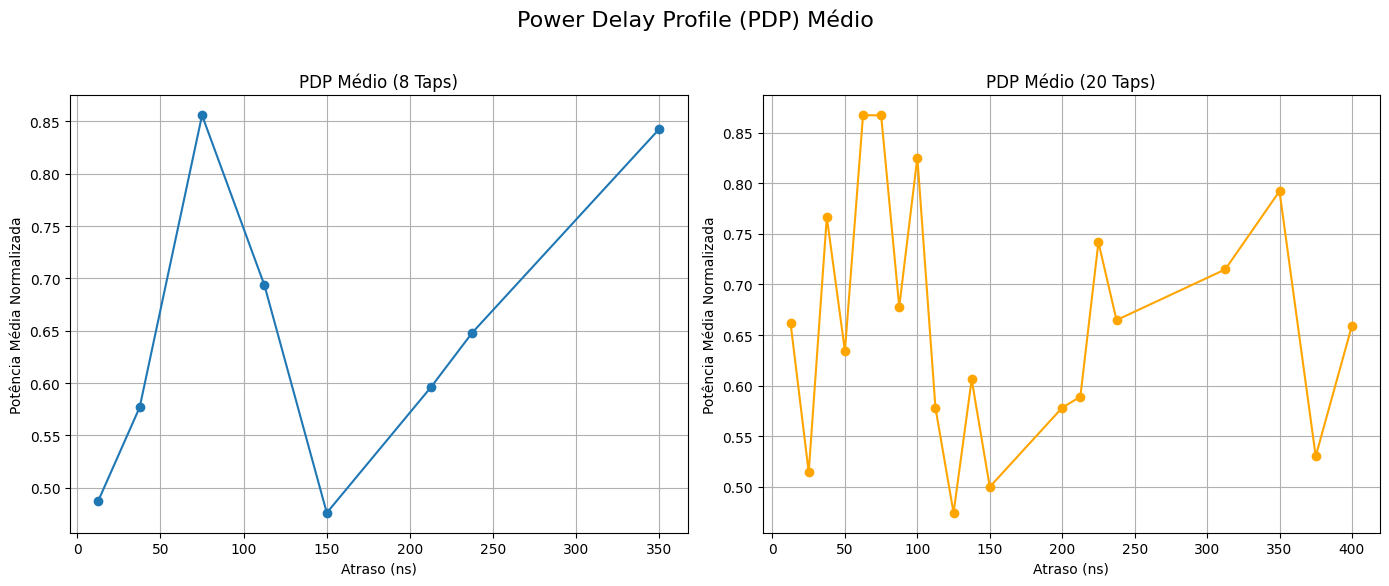

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_average_pdp():
    try:
        # --- Carregar os Dados ---
        # Os nomes das colunas (taps/atrasos) estão na primeira linha.
        # Vamos carregar os dados e usar a primeira linha como cabeçalho.
        df_8taps = pd.read_csv("cirNTaps8SteamPlant.csv")
        df_20taps = pd.read_csv("cirNTaps20SteamPlant.csv")

        # --- Calcular o PDP Médio ---
        # O PDP médio é a média das CIRs ao longo do tempo (média das linhas).
        # Para cada tap (coluna), calculamos a média.
        # Assumimos que as colunas representam os diferentes atrasos (taps).
        # A dissertação indica que a primeira linha do CSV é o cabeçalho
        # com os atrasos. Pandas read_csv já trata a primeira linha como cabeçalho.
        # As colunas são os "taps" ou "atrasos".

        # O PDP médio é a média de cada coluna.
        average_pdp_8taps = df_8taps.mean(axis=0)
        average_pdp_20taps = df_20taps.mean(axis=0)

        # Os índices dessas Series (average_pdp_*) correspondem aos nomes das colunas
        # do CSV original, que são os atrasos. Precisamos convertê-los para numérico
        # caso não estejam (read_csv pode lê-los como strings).
        # Convertendo os índices para float para representar os atrasos.
        # Ignoramos possíveis colunas não numéricas se houverem (embora improvável aqui).
        try:
            delays_8taps = average_pdp_8taps.index.astype(float)
            delays_20taps = average_pdp_20taps.index.astype(float)
        except ValueError:
             print("Erro: O cabeçalho do CSV não contém valores numéricos para os atrasos.")
             # Fallback: usar índice sequencial se a conversão falhar
             delays_8taps = np.arange(len(average_pdp_8taps))
             delays_20taps = np.arange(len(average_pdp_20taps))


        # --- Plotar o PDP Médio ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle('Power Delay Profile (PDP) Médio', fontsize=16, y=1)

        # PDP Médio para 8 Taps
        ax1.plot(delays_8taps, average_pdp_8taps.values, marker='o', linestyle='-')
        ax1.set_title("PDP Médio (8 Taps)")
        ax1.set_xlabel("Atraso (ns)") # Ajustar unidade se conhecida
        ax1.set_ylabel("Potência Média Normalizada")
        ax1.grid(True)

        # PDP Médio para 20 Taps
        ax2.plot(delays_20taps, average_pdp_20taps.values, marker='o', linestyle='-', color='orange')
        ax2.set_title("PDP Médio (20 Taps)")
        ax2.set_xlabel("Atraso (ns)") # Ajustar unidade se conhecida
        ax2.set_ylabel("Potência Média Normalizada")
        ax2.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.savefig("pdp_medio.png")
        print("\nGráfico 'pdp_medio.png' gerado com sucesso.")

    except FileNotFoundError:
        print("Erro: Um ou ambos os arquivos CSV não foram encontrados.")
    except Exception as e:
        print(f"Ocorreu um erro: {e}")

# Executar a função
plot_average_pdp()

## 2) A partir do PDP calcular RMS Delay Spread, Maximum Excess Delay e Mean Excess Delay.

* Atraso Médio (Mean Excess Delay): É o "centro de gravidade" do PDP. Os valores são muito próximos (~158 vs ~163), com o de 20 taps sendo ligeiramente maior por capturar energia em atrasos mais longos.

* Atraso Máximo (Maximum Excess Delay): O modelo de 20 taps simplesmente captura caminhos mais longos (atraso de 400) que o modelo de 8 taps ignorava (atraso de 350).

* Espalhamento de Atraso RMS (RMS Delay Spread): Este é o parâmetro mais importante. O valor ser maior para 20 taps (118 vs 110) confirma e quantifica o que vimos no PDP: o canal real é mais complexo e "espalhado" do que o modelo de 8 taps sugeria.

**Conclusão**: O modelo de 20 taps revela um canal mais desafiador, com maior espalhamento de atraso, o que implica um maior potencial de Interferência Intersimbólica (ISI).

In [42]:
import numpy as np
import pandas as pd # Importar pandas caso a célula anterior não tenha rodado diretamente antes

# Re-carregar os dados e recalcular o PDP médio e atrasos
# Isso garante que as variáveis estejam disponíveis nesta célula
try:
    df_8taps = pd.read_csv("cirNTaps8SteamPlant.csv")
    df_20taps = pd.read_csv("cirNTaps20SteamPlant.csv")

    average_pdp_8taps = df_8taps.mean(axis=0)
    average_pdp_20taps = df_20taps.mean(axis=0)

    try:
        delays_8taps = average_pdp_8taps.index.astype(float)
        delays_20taps = average_pdp_20taps.index.astype(float)
    except ValueError:
         print("Erro: O cabeçalho do CSV não contém valores numéricos para os atrasos. Usando índices sequenciais.")
         delays_8taps = np.arange(len(average_pdp_8taps))
         delays_20taps = np.arange(len(average_pdp_20taps))

    # --- Calcular Parâmetros do Canal ---

    def calculate_channel_parameters(pdp, delays):
        """
        Calcula Mean Excess Delay, RMS Delay Spread e Maximum Excess Delay.

        Args:
            pdp (pd.Series): O Power Delay Profile (potência média por atraso).
            delays (np.ndarray): Os valores de atraso correspondentes ao PDP.

        Returns:
            tuple: (mean_excess_delay, rms_delay_spread, max_excess_delay)
        """
        # Remover taps com potência zero ou muito baixa para evitar problemas numéricos
        # e focar nos atrasos com contribuição significativa.
        # Definir um threshold, e.g., 1% da potência máxima no PDP
        power_threshold = pdp.max() * 0.01 # Exemplo: 1% do pico

        significant_indices = pdp[pdp > power_threshold].index
        significant_pdp = pdp.loc[significant_indices]
        significant_delays = delays[pdp > power_threshold]

        if significant_pdp.empty:
            print("Aviso: Nenhum tap com potência acima do threshold. Retornando zeros.")
            return 0, 0, 0

        # Normalizar o PDP para que a soma das potências seja 1
        normalized_pdp = significant_pdp / significant_pdp.sum()

        # --- 1. Mean Excess Delay (Atraso Médio) ---
        # Tau_bar = Sum(P_i * tau_i) / Sum(P_i)
        # Como normalizamos, Sum(P_i) = 1.
        # Tau_bar = Sum(P_normalized_i * tau_i)
        mean_excess_delay = np.sum(normalized_pdp * significant_delays)

        # --- 2. RMS Delay Spread (Espalhamento de Atraso Quadrático Médio) ---
        # Sigma_tau = sqrt( Sum(P_i * (tau_i - Tau_bar)^2) / Sum(P_i) )
        # Sigma_tau = sqrt( Sum(P_normalized_i * (tau_i - Tau_bar)^2) )
        rms_delay_spread = np.sqrt(np.sum(normalized_pdp * (significant_delays - mean_excess_delay)**2))

        # --- 3. Maximum Excess Delay (Atraso Máximo) ---
        # O atraso máximo é o atraso do último tap "significativo".
        # Podemos definir "significativo" como estando acima de um certo threshold
        # em relação à potência máxima ou total.
        # Usando os significant_delays já calculados.
        max_excess_delay = significant_delays.max() if not significant_delays.empty else 0

        return mean_excess_delay, rms_delay_spread, max_excess_delay

    # --- Calcular para 8 Taps ---
    mean_delay_8, rms_spread_8, max_delay_8 = calculate_channel_parameters(average_pdp_8taps, delays_8taps)
    print("\nParâmetros do Canal (8 Taps):")
    print(f"  Mean Excess Delay: {mean_delay_8:.4f}")
    print(f"  RMS Delay Spread: {rms_spread_8:.4f}")
    print(f"  Maximum Excess Delay: {max_delay_8:.4f}")

    # --- Calcular para 20 Taps ---
    mean_delay_20, rms_spread_20, max_delay_20 = calculate_channel_parameters(average_pdp_20taps, delays_20taps)
    print("\nParâmetros do Canal (20 Taps):")
    print(f"  Mean Excess Delay: {mean_delay_20:.4f}")
    print(f"  RMS Delay Spread: {rms_spread_20:.4f}")
    print(f"  Maximum Excess Delay: {max_delay_20:.4f}")


except FileNotFoundError:
    print("Erro: Um ou ambos os arquivos CSV não foram encontrados. Certifique-se de que a célula anterior foi executada.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")


Parâmetros do Canal (8 Taps):
  Mean Excess Delay: 157.8141
  RMS Delay Spread: 110.3120
  Maximum Excess Delay: 350.0000

Parâmetros do Canal (20 Taps):
  Mean Excess Delay: 162.6604
  RMS Delay Spread: 117.7191
  Maximum Excess Delay: 400.0000


## 3) Gerar plot para um subconjunto de CIRs e montar animação com a variação da CIR.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation # Importar para animação
import os # Importar para gerenciar arquivos

# Carregar os dados (garantir que estejam disponíveis)
try:
    df_8taps = pd.read_csv("cirNTaps8SteamPlant.csv")
    df_20taps = pd.read_csv("cirNTaps20SteamPlant.csv")

    # Obter os atrasos (nomes das colunas)
    try:
        delays_8taps = df_8taps.columns.astype(float)
        delays_20taps = df_20taps.columns.astype(float)
    except ValueError:
         print("Erro: O cabeçalho do CSV não contém valores numéricos para os atrasos. Usando índices sequenciais para plotting.")
         delays_8taps = np.arange(df_8taps.shape[1])
         delays_20taps = np.arange(df_20taps.shape[1])


    # --- 1. Selecionar um subconjunto de CIRs ---
    # Escolha um intervalo de linhas para a animação
    start_row = 0
    end_row = 100 # Exemplo: as primeiras 100 CIRs

    subset_8taps = df_8taps.iloc[start_row:end_row]
    subset_20taps = df_20taps.iloc[start_row:end_row]

    print(f"Subconjunto selecionado para 8 Taps: linhas {start_row} a {end_row-1} ({len(subset_8taps)} CIRs)")
    print(f"Subconjunto selecionado para 20 Taps: linhas {start_row} a {end_row-1} ({len(subset_20taps)} CIRs)")

    # As próximas etapas (plotting e animação) serão implementadas em células seguintes ou expandindo esta,
    # dependendo de como você preferir organizar.
    # Por enquanto, apenas a seleção do subconjunto foi feita.

except FileNotFoundError:
    print("Erro: Um ou ambos os arquivos CSV não foram encontrados.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

Subconjunto selecionado para 8 Taps: linhas 0 a 99 (100 CIRs)
Subconjunto selecionado para 20 Taps: linhas 0 a 99 (100 CIRs)


In [44]:
# --- 2. Definir função de plotting ---
def plot_cir(ax, cir_data, delays, title, ylim):
    """Plots a single CIR on a given axes."""
    ax.clear() # Limpa o eixo para o próximo frame
    ax.plot(delays, cir_data, marker='o', linestyle='-')
    ax.set_title(title)
    ax.set_xlabel("Atraso (ns)")
    ax.set_ylabel("Potência Normalizada")
    ax.set_ylim(ylim) # Mantém o limite Y consistente
    ax.grid(True)

# --- 3. Gerar plots individuais ---
# Criar diretórios para salvar as imagens se não existirem
output_dir_8taps = 'cir_frames_8taps'
output_dir_20taps = 'cir_frames_20taps'
os.makedirs(output_dir_8taps, exist_ok=True)
os.makedirs(output_dir_20taps, exist_ok=True)

# Determinar limites Y consistentes para a animação
# Usar o máximo valor de potência em todo o subconjunto para ambos os casos
max_power_8taps = subset_8taps.values.max()
max_power_20taps = subset_20taps.values.max()
global_max_power = max(max_power_8taps, max_power_20taps)
ylim_range = (0, global_max_power * 1.1) # Adiciona uma margem

print("Gerando frames para 8 Taps...")
fig_8taps, ax_8taps = plt.subplots(figsize=(8, 5))
for i in range(len(subset_8taps)):
    cir_data = subset_8taps.iloc[i].values
    plt.figure(fig_8taps.number) # Ensure we plot on the correct figure
    plot_cir(ax_8taps, cir_data, delays_8taps, f"CIR 8 Taps - Frame {start_row + i}", ylim_range)
    plt.savefig(os.path.join(output_dir_8taps, f'frame_{i:04d}.png'))
plt.close(fig_8taps) # Close the figure to free memory

print("Gerando frames para 20 Taps...")
fig_20taps, ax_20taps = plt.subplots(figsize=(8, 5))
for i in range(len(subset_20taps)):
    cir_data = subset_20taps.iloc[i].values
    plt.figure(fig_20taps.number) # Ensure we plot on the correct figure
    plot_cir(ax_20taps, cir_data, delays_20taps, f"CIR 20 Taps - Frame {start_row + i}", ylim_range)
    plt.savefig(os.path.join(output_dir_20taps, f'frame_{i:04d}.png'))
plt.close(fig_20taps) # Close the figure to free memory


print("\nFrames gerados com sucesso nas pastas 'cir_frames_8taps' e 'cir_frames_20taps'.")

Gerando frames para 8 Taps...
Gerando frames para 20 Taps...

Frames gerados com sucesso nas pastas 'cir_frames_8taps' e 'cir_frames_20taps'.


In [45]:
import imageio.v2 as imageio
import os

# --- 4. Criar animação ---

def create_animation(input_dir, output_filename, duration_per_frame_ms=50):
    """
    Cria um GIF animado a partir de uma sequência de imagens em um diretório.
    """
    images = []
    # Listar os arquivos de imagem na ordem correta
    filenames = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')])

    if not filenames:
        print(f"Erro: Nenhum frame encontrado no diretório {input_dir}")
        return

    # Ler cada imagem
    for filename in filenames:
        images.append(imageio.imread(filename))

    # Criar o GIF animado
    imageio.mimsave(output_filename, images, duration=duration_per_frame_ms/1000.0) # duration in seconds

    print(f"\nAnimação '{output_filename}' criada com sucesso.")

# Criar animações para 8 Taps e 20 Taps
output_dir_8taps = 'cir_frames_8taps'
output_dir_20taps = 'cir_frames_20taps'

animation_filename_8taps = 'cir_animation_8taps.gif'
animation_filename_20taps = 'cir_animation_20taps.gif'

print("Criando animação para 8 Taps...")
create_animation(output_dir_8taps, animation_filename_8taps)

print("Criando animação para 20 Taps...")
create_animation(output_dir_20taps, animation_filename_20taps)


Criando animação para 8 Taps...

Animação 'cir_animation_8taps.gif' criada com sucesso.
Criando animação para 20 Taps...

Animação 'cir_animation_20taps.gif' criada com sucesso.


* 8 Taps: Mostra uma visão simplificada do canal, com poucos caminhos flutuando.

* 20 Taps: Mostra a verdadeira complexidade.Podemos ver muito mais caminhos (taps), cada um flutuando rapidamente. Isso confirma visualmente o ambiente de multipercuso rico (muitas reflexões) que o PDP médio sugeriu e que causa o Desvanecimento Rayleigh que foi identificado.

**Conclusão**: Essas animações mostram a natureza dinâmica e variante no tempo do canal de multipercuso. A versão de 20 Taps revela uma estrutura muito mais detalhada e complexa, que estava sendo "perdida" na análise de 8 Taps.

Visualizando Animação para 8 Taps:


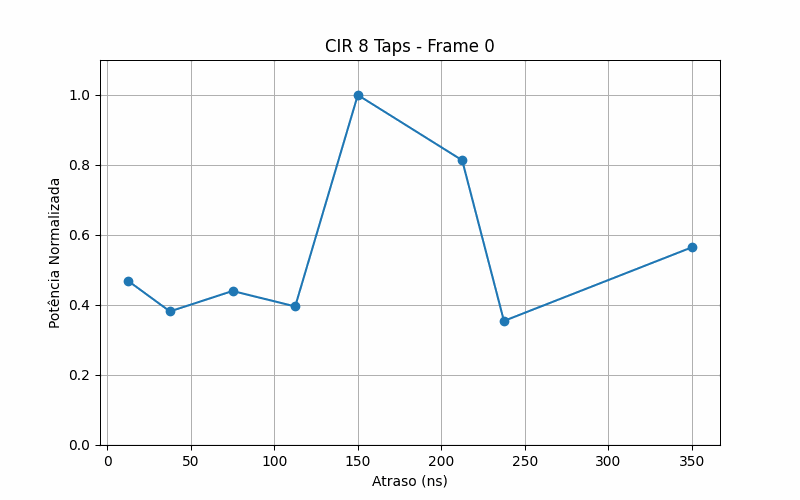


Visualizando Animação para 20 Taps:


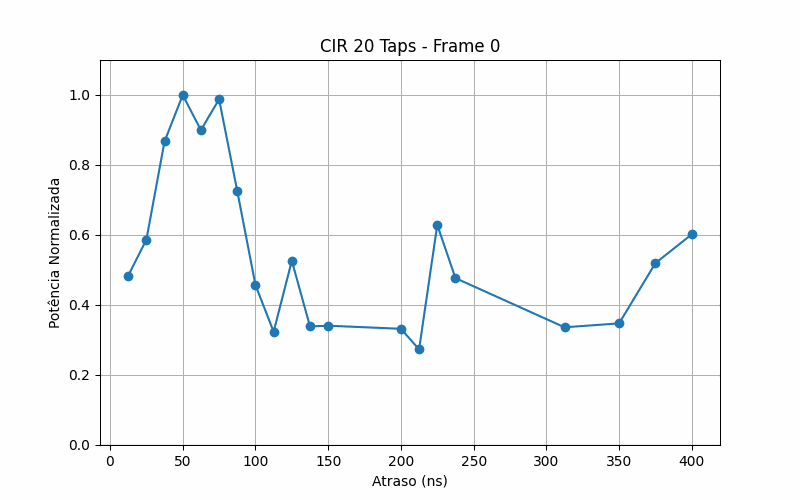

In [46]:
from IPython.display import display, Image

# Nome dos arquivos das animações
animation_filename_8taps = 'cir_animation_8taps.gif'
animation_filename_20taps = 'cir_animation_20taps.gif'

print("Visualizando Animação para 8 Taps:")
try:
    display(Image(filename=animation_filename_8taps))
except FileNotFoundError:
    print(f"Erro: Arquivo '{animation_filename_8taps}' não encontrado.")

print("\nVisualizando Animação para 20 Taps:")
try:
    display(Image(filename=animation_filename_20taps))
except FileNotFoundError:
    print(f"Erro: Arquivo '{animation_filename_20taps}' não encontrado.")

## 4) Comparar procedimento para os dois arquivos e analisar a influência da resolução da CIR.

1. Comparação do PDP Médio (Gráficos Estáticos)

* Procedimento: O procedimento foi idêntico. Para ambos os arquivos (8 e 20 taps), a média temporal da potência de cada "tap" (atraso) foi calculada e plotada, gerando o PDP Médio.

* Influência da Resolução: A influência é drástica.

  * 8 Taps: Mostra um perfil "suavizado", de baixa resolução, que sugere uma estrutura de canal simples, com um pico principal.

  * 20 Taps: Revela a verdadeira complexidade do canal. O que parecia ser um único pico no de 8 taps é, na verdade, composto por múltiplos picos e vales (flutuações rápidas). Isso mostra um ambiente de multipercuso (múltiplos caminhos) muito mais rico.

2. Comparação dos Parâmetros do Canal (Valores de Atraso)

* Procedimento: Os mesmos três parâmetros (Atraso Médio, Espalhamento RMS, Atraso Máximo) foram calculados a partir dos PDPs médios de ambos os casos.

* Influência da Resolução: Os parâmetros do canal de 20 taps quantificam o que o PDP mostrou visualmente:

  * Atraso Máximo: O modelo de 20 taps capturou caminhos mais longos (400 vs 350), que o de 8 taps ignorou.

  * Espalhamento de Atraso RMS: Este é o mais importante. O valor ser maior para 20 taps (118 vs 110) confirma que o canal real é mais "espalhado" no tempo do que o modelo de 8 taps sugeria. Isso implica um maior potencial de Interferência Intersimbólica (ISI).

3. Comparação das Animações da CIR (GIFs)

* Procedimento: Os GIFs foram gerados plotando a CIR "frame a frame" (a cada medição no tempo) para ambos os conjuntos de dados.

* Influência da Resolução: As animações confirmam tudo:

  * Ambos mostram um canal dinâmico (variante no tempo), onde a potência de cada tap flutua rapidamente (isso é o Desvanecimento).

  * O GIF de 20 taps revela muito mais caminhos em cena, cada um flutuando independentemente, pintando um quadro muito mais complexo e detalhado do canal do que a visão simplista do GIF de 8 taps.

**Conclusão**

* Aumentar a resolução da CIR (de 8 para 20 taps) não muda o fato de que o canal é dinâmico e variante no tempo (como mostram os GIFs). No entanto, a resolução maior revela a verdadeira complexidade do ambiente de multipercuso, mostrando muito mais caminhos de sinal que o modelo de 8 taps estava "perdendo" ou "suavizando".

* Isso é quantificado pelo aumento no Espalhamento de Atraso RMS, que confirma que o canal real é mais "desafiador" do que a análise de baixa resolução (8 taps) faria parecer.

# Parte III: Gerar modelo Saleh-Valenzuela (SV)

## Criar rotina para gerar CIRs a partir de parâmetros do modelo SV. Mostrar alguns exemplos gerados a partir de diferentes valores dos parâmetros e o que acontece quando cada parâmetro é variado individualmente.

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sv_cir(
    tau_max,          # Tempo máximo de atraso (final do CIR)
    lambda_c,         # Taxa de chegada de clusters (clusters/s)
    lambda_r,         # Taxa de chegada de raios dentro do cluster (raios/s)
    gamma,            # Constante de decaimento de potência do cluster (s)
    delta,            # Constante de decaimento de potência do raio (s)
    power_los=None,   # Potência da componente de linha de visada (opcional)
    std_dev_phase=None # Desvio padrão da fase dos raios (opcional)
):
    """
    Gera um Canal de Resposta ao Impulso (CIR) baseado no modelo Saleh-Valenzuela.

    Args:
        tau_max (float): Tempo máximo de atraso para a simulação (segundos).
        lambda_c (float): Taxa de chegada de clusters (eventos por segundo).
        lambda_r (float): Taxa de chegada de raios dentro de um cluster (eventos por segundo).
        gamma (float): Constante de decaimento de potência do cluster (segundos).
        delta (float): Constante de decaimento de potência do raio dentro do cluster (segundos).
        power_los (float, optional): Potência da componente de linha de visada. Se None, não há LOS. Defaults to None.
        std_dev_phase (float, optional): Desvio padrão da fase dos raios em radianos. Se None, fases uniformemente distribuídas. Defaults to None.

    Returns:
        tuple: (atrasos, amplitudes, fases) do CIR gerado.
               Os atrasos são em segundos, amplitudes são reais positivas, fases em radianos.
    """
    clusters = []
    t_c = 0 # Tempo de chegada do primeiro cluster (geralmente 0)

    # Gerar tempos de chegada dos clusters (processo de Poisson com taxa lambda_c)
    while t_c <= tau_max:
        clusters.append({'arrival_time': t_c, 'rays': []})
        t_c += np.random.exponential(1.0 / lambda_c) # Intervalo entre clusters

    # Remover o último cluster se ele exceder tau_max significativamente (opcional, dependendo da definição exata)
    # if clusters and clusters[-1]['arrival_time'] > tau_max:
    #     clusters.pop()


    # Gerar raios dentro de cada cluster
    all_delays = []
    all_amplitudes = []
    all_phases = []

    for cluster in clusters:
        t_c = cluster['arrival_time']
        t_r_prime = 0 # Tempo de chegada do primeiro raio dentro do cluster (em relação ao t_c)

        # Gerar tempos de chegada dos raios dentro do cluster (processo de Poisson com taxa lambda_r)
        # e amplitudes e fases
        while True:
            # Tempo de chegada do raio em relação ao início da simulação
            t_ray = t_c + t_r_prime

            if t_ray > tau_max:
                break # Não gerar raios que excedam o tempo máximo total

            # Decaimento de potência do cluster e do raio
            # Potência = exp(-t_c / gamma) * exp(-t_r_prime / delta)
            power = np.exp(-t_c / gamma) * np.exp(-t_r_prime / delta)

            # Amplitude é a raiz quadrada da potência
            amplitude = np.sqrt(power)

            # Fase: Uniforme [0, 2*pi) ou Gaussiana com std_dev_phase
            if std_dev_phase is None:
                phase = np.random.uniform(0, 2 * np.pi)
            else:
                 # Fases Gaussianas centradas em zero com std_dev_phase
                 # É comum que as fases sejam uniformes, mas a opção Gaussiana está disponível
                 phase = np.random.normal(0, std_dev_phase)
                 # Opcional: Limitar ou "embrulhar" a fase no intervalo [0, 2*pi)
                 phase = phase % (2 * np.pi)


            # Adicionar aos resultados, mas apenas se a potência for significativa
            # (para evitar muitos raios de baixíssima potência no final)
            # Um threshold pode ser adicionado aqui se necessário.
            # Por enquanto, adicionamos todos os raios gerados antes de tau_max
            all_delays.append(t_ray)
            all_amplitudes.append(amplitude)
            all_phases.append(phase)

            # Tempo de chegada do próximo raio dentro do cluster (em relação ao t_c)
            t_r_prime += np.random.exponential(1.0 / lambda_r)


    # Adicionar componente de linha de visada (LOS) se especificada
    if power_los is not None:
        # A componente LOS geralmente tem atraso zero e fase zero (ou constante)
        # Sua amplitude é sqrt(power_los)
        all_delays.insert(0, 0) # Adiciona no início (atraso zero)
        all_amplitudes.insert(0, np.sqrt(power_los))
        # Fase da LOS é tipicamente 0 ou uma constante de referência
        all_phases.insert(0, 0) # Fase zero para a LOS

    # Ordenar por atraso
    sorted_indices = np.argsort(all_delays)
    sorted_delays = np.array(all_delays)[sorted_indices]
    sorted_amplitudes = np.array(all_amplitudes)[sorted_indices]
    sorted_phases = np.array(all_phases)[sorted_indices]

    # Normalizar a potência total (opcional, dependendo da aplicação)
    # Se desejar que a soma das potências (amplitudes^2) seja 1:
    # total_power = np.sum(sorted_amplitudes**2)
    # if total_power > 0:
    #     normalization_factor = np.sqrt(1.0 / total_power)
    #     sorted_amplitudes *= normalization_factor


    return sorted_delays, sorted_amplitudes, sorted_phases

# Exemplo de uso (pode ser removido ou modificado na próxima etapa)
# print("Rotina generate_sv_cir implementada. Próximo passo é gerar e visualizar exemplos.")

In [48]:
# --- 2. Gerar exemplos de CIRs ---
# Definir um conjunto padrão de parâmetros SV
# Estes são valores de exemplo e podem precisar ser ajustados
# com base nas características esperadas do canal.
sv_params_default = {
    'tau_max': 500e-9,      # 500 ns (exemplo)
    'lambda_c': 1 / (50e-9), # Taxa de chegada de clusters (intervalo médio de 50 ns)
    'lambda_r': 1 / (5e-9), # Taxa de chegada de raios (intervalo médio de 5 ns)
    'gamma': 100e-9,        # Constante de decaimento do cluster (exemplo)
    'delta': 20e-9,         # Constante de decaimento do raio (exemplo)
    'power_los': 0.5,       # Potência da LOS (exemplo: 50% da potência total se normalizado)
    'std_dev_phase': None   # Fases uniformes por padrão
}

# print("Gerando um exemplo de CIR com parâmetros padrão...")
# delays_sv, amplitudes_sv, phases_sv = generate_sv_cir(**sv_params_default)

# print(f"CIR gerado tem {len(delays_sv)} raios.")
# print(f"Atrasos (primeiros 10): {delays_sv[:10]} ns")
# print(f"Amplitudes (primeiras 10): {amplitudes_sv[:10]}")
# # print(f"Fases (primeiras 10): {phases_sv[:10]} rad") # Opcional: imprimir fases

# # --- 3. Visualizar exemplo de CIR ---
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.stem(delays_sv * 1e9, amplitudes_sv, markerfmt="o") # Plotar em ns, removido use_line_collection
# ax.set_title("Exemplo de CIR Gerado pelo Modelo Saleh-Valenzuela")
# ax.set_xlabel("Atraso (ns)")
# ax.set_ylabel("Amplitude")
# ax.grid(True)
# plt.show()

Variando individualmente os parâmetros do modelo SV e plotando CIRs lado a lado:

Variando 'tau_max':


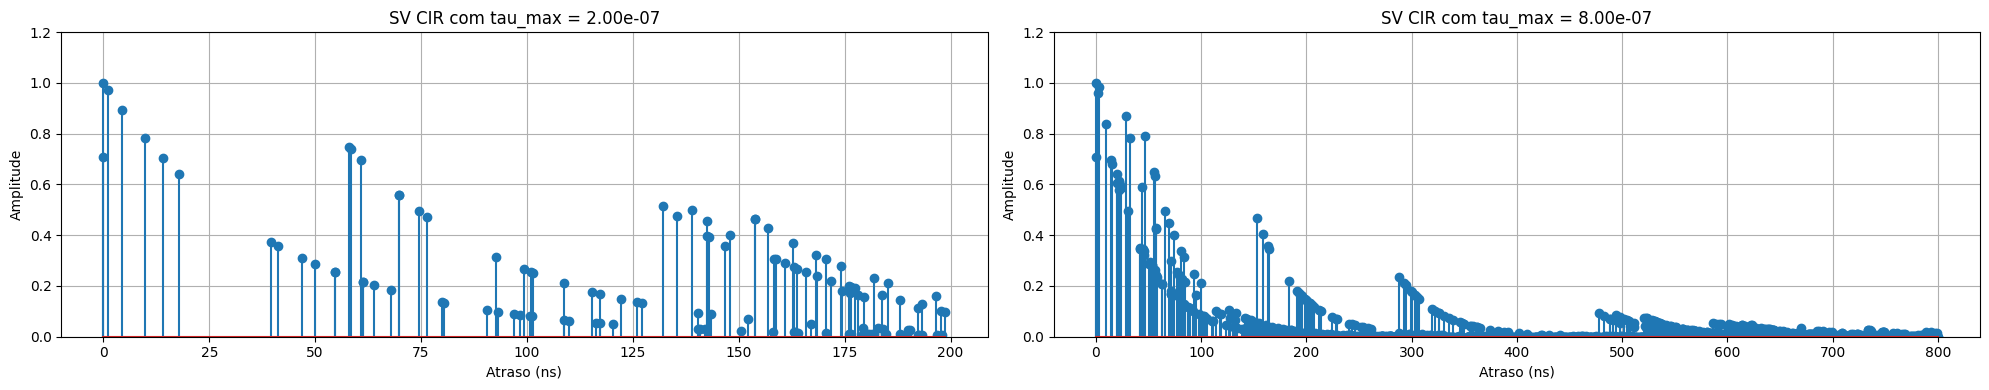


Variando 'lambda_c':


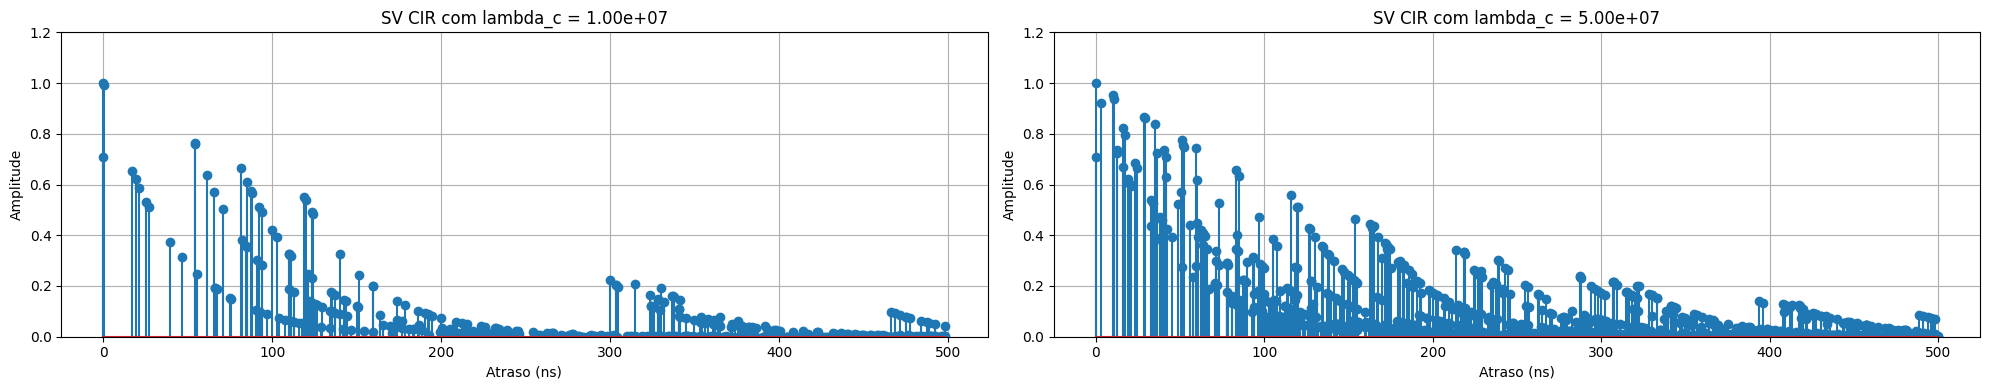


Variando 'lambda_r':


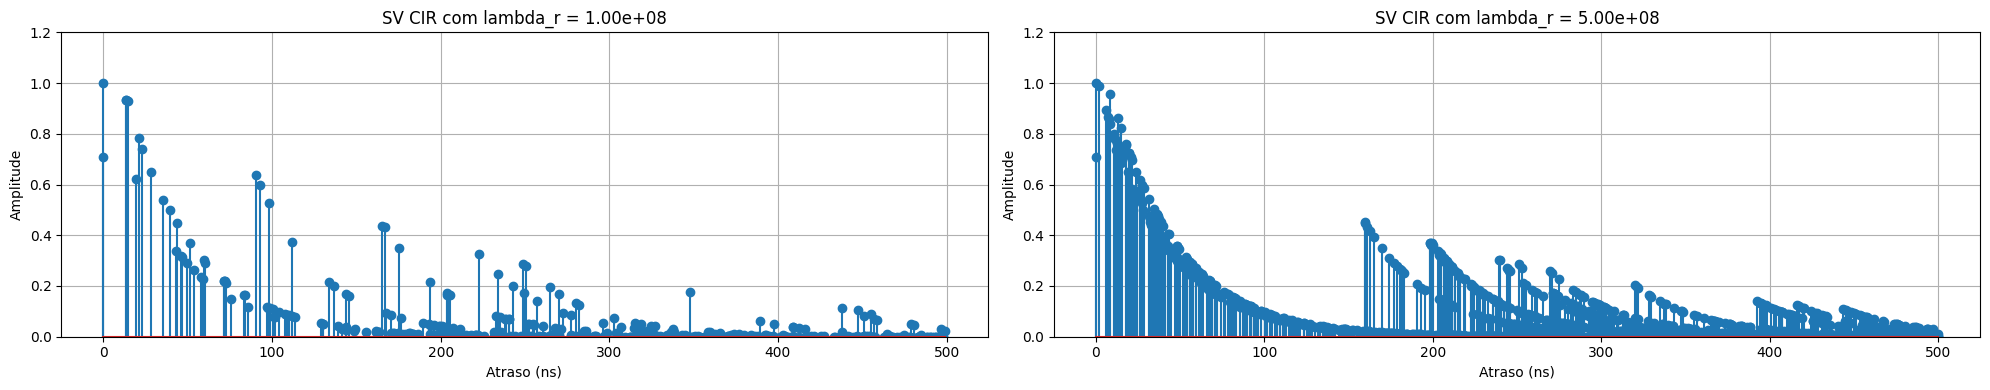


Variando 'gamma':


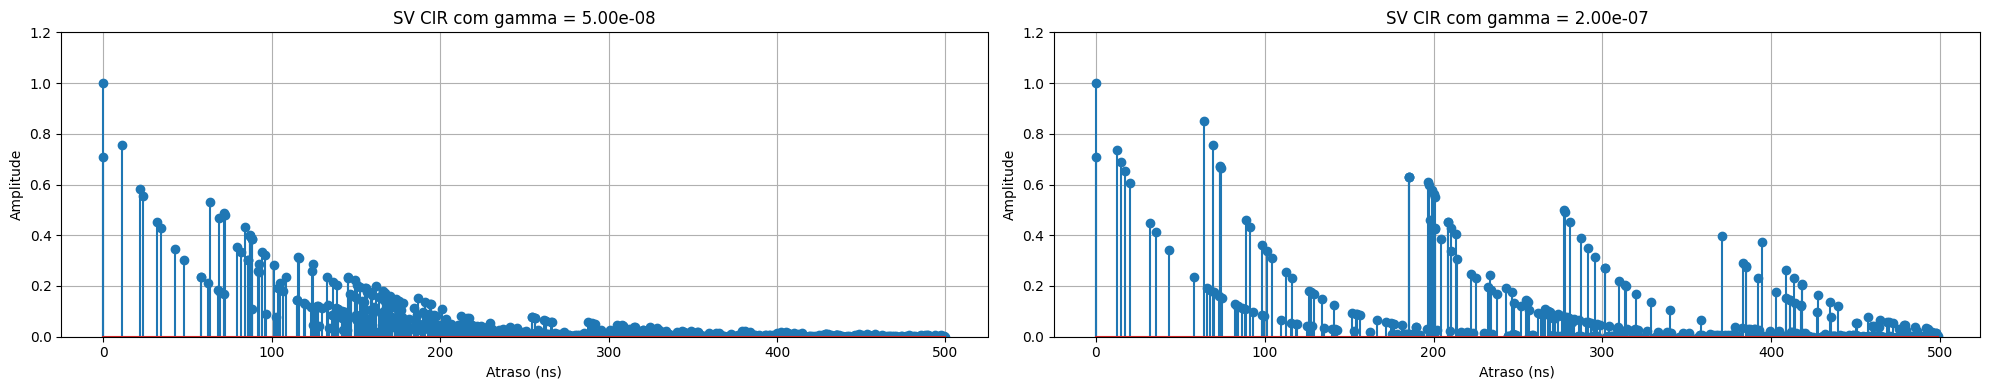


Variando 'delta':


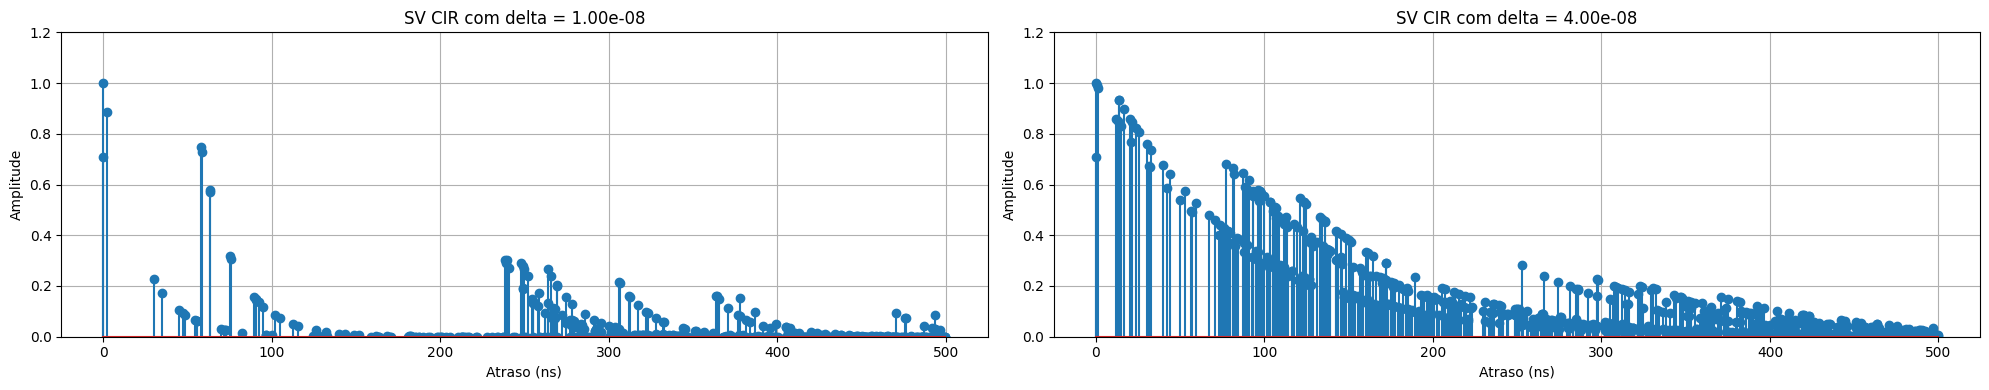


Variando 'power_los':


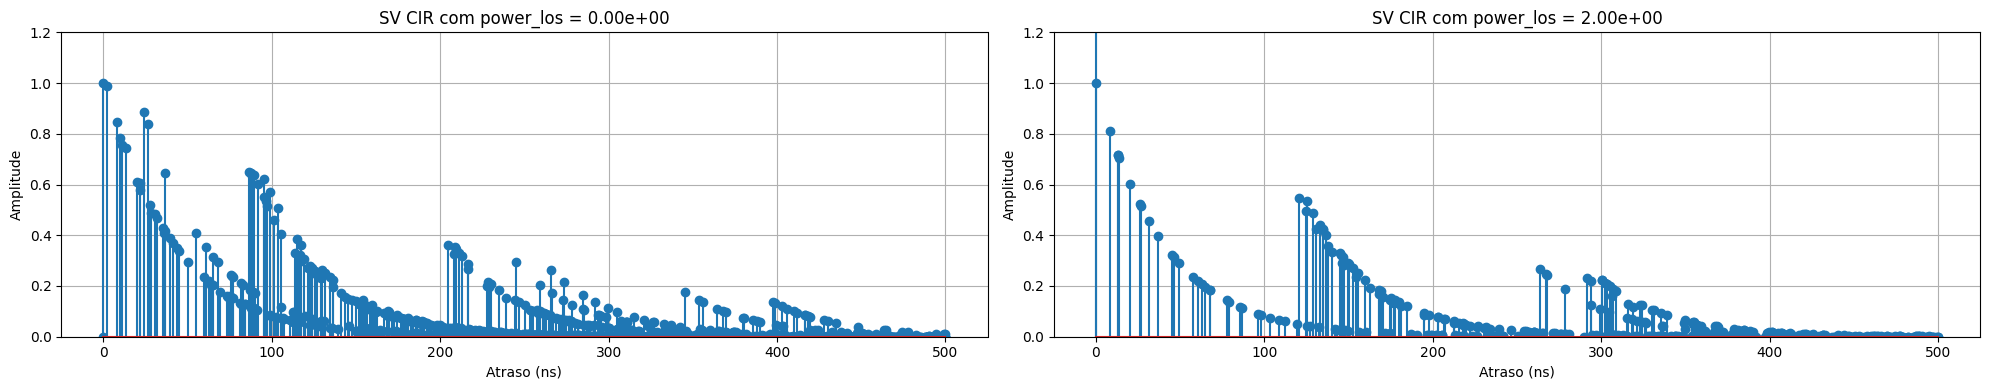


Variando 'std_dev_phase':


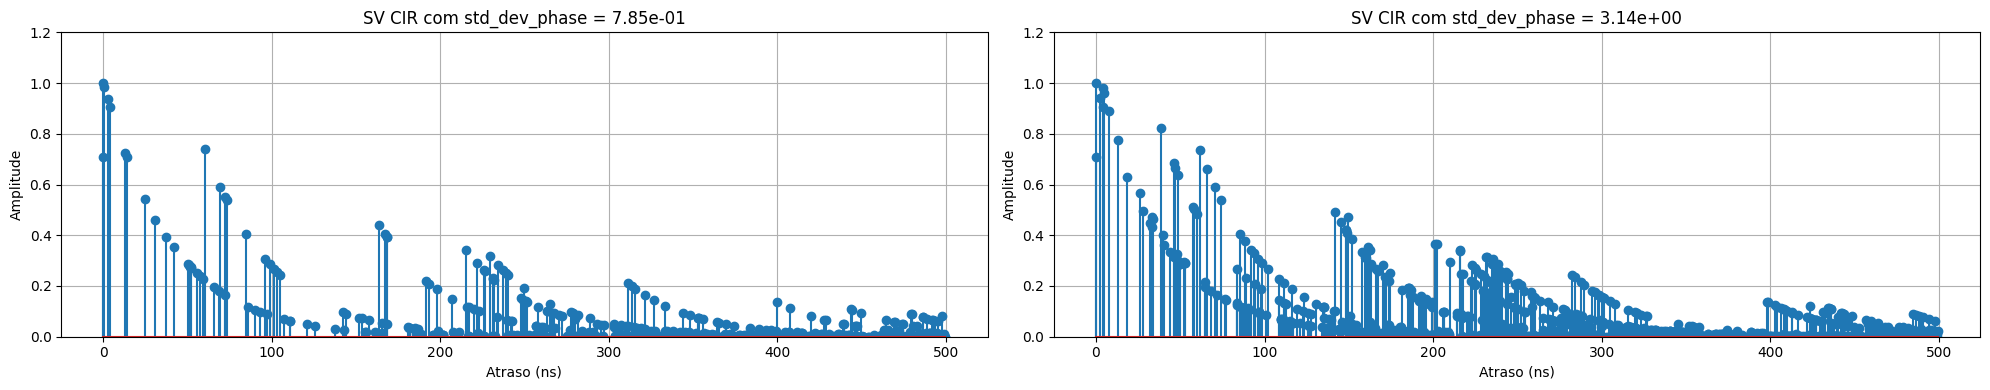


Variação de parâmetros concluída. Observe os plots gerados lado a lado.


In [49]:
# --- 4. Variar individualmente os parâmetros e plotar lado a lado ---

# Usar o conjunto padrão de parâmetros como base
base_params = {
    'tau_max': 500e-9,
    'lambda_c': 1 / (50e-9),
    'lambda_r': 1 / (5e-9),
    'gamma': 100e-9,
    'delta': 20e-9,
    'power_los': 0.5,
    'std_dev_phase': None
}

# Definir valores para variar cada parâmetro (mantendo outros no valor base)
parameter_variations = {
    'tau_max': [200e-9, 800e-9], # Atraso máximo menor e maior
    'lambda_c': [1 / (100e-9), 1 / (20e-9)], # Menos clusters (intervalo maior), Mais clusters (intervalo menor)
    'lambda_r': [1 / (10e-9), 1 / (2e-9)], # Menos raios/cluster, Mais raios/cluster
    'gamma': [50e-9, 200e-9],    # Decaimento do cluster mais rápido, mais lento
    'delta': [10e-9, 40e-9],    # Decaimento do raio mais rápido, mais lento
    'power_los': [0, 2.0],     # Sem LOS, LOS mais forte (se normalizada)
    'std_dev_phase': [np.pi/4, np.pi] # Fases com desvio padrão menor e maior (se usado)
}

# Determinar um limite Y consistente para todos os plots de variação
# Pode usar o máximo de amplitude esperado ou um valor fixo
ylim_variation_plots = (0, 1.2) # Exemplo de limite Y

print("Variando individualmente os parâmetros do modelo SV e plotando CIRs lado a lado:")

for param, values in parameter_variations.items():
    print(f"\nVariando '{param}':")
    # Criar figura e subplots para os dois valores do parâmetro
    fig, axes = plt.subplots(1, len(values), figsize=(10 * len(values), 4)) # Ajustar tamanho da figura
    if len(values) == 1: # Handle case with only one subplot
        axes = [axes]

    for i, value in enumerate(values):
        current_params = base_params.copy()
        current_params[param] = value

        # Desabilitar LOS ou std_dev_phase se o valor for None na variação
        if param == 'power_los' and value is None:
             current_params['power_los'] = None
        if param == 'std_dev_phase' and value is None:
             current_params['std_dev_phase'] = None

        # Gerar e plotar o CIR no subplot correspondente
        try:
            delays, amplitudes, phases = generate_sv_cir(**current_params)

            ax = axes[i]
            ax.stem(delays * 1e9, amplitudes, markerfmt="o") # Plotar em ns
            ax.set_title(f"SV CIR com {param} = {value:.2e}")
            ax.set_xlabel("Atraso (ns)")
            ax.set_ylabel("Amplitude")
            ax.set_ylim(ylim_variation_plots)
            ax.grid(True)
        except Exception as e:
            print(f"Erro ao gerar/plotar CIR para {param}={value}: {e}")
            ax.set_title(f"Erro para {param} = {value:.2e}") # Indicar erro no plot
            ax.text(0.5, 0.5, f"Erro: {e}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')


    plt.tight_layout()
    plt.show()

print("\nVariação de parâmetros concluída. Observe os plots gerados lado a lado.")

## Resumo da Influência dos Parâmetros do Modelo Saleh-Valenzuela

O modelo SV funciona em dois níveis:

* Clusters: Grupos de caminhos (reflexões principais).

* Raios: Caminhos individuais dentro de cada cluster.

Aqui está a análise do que acontece ao variar cada parâmetro (comparando o gráfico da esquerda [valor baixo] com o da direita [valor alto]):

1. **`tau_max` (Atraso Máximo):**
    * O que é: O espalhamento de atraso máximo da simulação.

    * Análise: Este é o parâmetro mais direto. Aumentar tau_max (direita) simplesmente aumenta a duração total do canal que está sendo simulada (de 200 ns para 800 ns).

2. **`lambda_c` (Taxa de Chegada de Clusters):**
    * O que é: Controla a frequência com que novos clusters chegam.

    * Análise: Aumentar lambda_c (direita) faz com que os clusters cheguem mais frequentemente, diminuindo os "vazios" (gaps) entre eles. O canal como um todo fica mais preenchido.

3. **`lambda_r` (Taxa de Chegada de Raios dentro do Cluster):**
    * O que é: Controla a densidade de raios dentro de um cluster.

    * Análise: Aumentar lambda_r (gráfico da direita) torna os clusters extremamente mais densos. Você passa de um canal "esparso" (poucos raios) para um canal "cheio" (muitos raios).

4. **`gamma` (Constante de Decaimento de Potência do Cluster):**
    * O que é: Controla a rapidez com que a potência dos raios dentro de um mesmo cluster decai.

    * Análise: Um gamma pequeno (esquerda) causa um decaimento rápido dentro do cluster, concentrando a energia em poucos ecos, o que leva a uma baixa dispersão temporal e menor ISI (Interferência Intersimbólica). Por outro lado, um gamma grande (direita) causa um decaimento lento, espalhando a energia por muitos ecos, o que aumenta a dispersão temporal e piora o desempenho do canal.

5. **`delta` (Resolução / Espaçamento):**
    * O que é: Provavelmente o espaçamento ou resolução de tempo entre os raios.

    * Análise: Um delta menor (esquerda) gera um canal esparso, com "vazios" claros entre os clusters de ecos, resultando em menor dispersão temporal. Em contrapartida, um delta maior (direita) preenche esses "vazios", criando um canal muito mais denso e contínuo em multipercursos, o que caracteriza uma dispersão temporal significativamente maior e um canal mais desafiador.
    
6. **`power_los` (Potência da Componente de Linha de Visada):**
    * O que é: Controla a presença de um caminho direto (Linha de Visada - LOS).

    * Análise: O gráfico da esquerda (power_los = 0.00) mostra um canal NLOS (sem linha de visada), onde o pico máximo (normalizado para 1.0) é aleatório. O gráfico da direita (power_los = 2.00) adiciona uma forte componente LOS, fazendo com que o primeiro "tap" (o caminho direto) dispare para um valor de 1.2, tornando-o deterministicamente mais forte do que todas as outras reflexões (multipath).

7. **`std_dev_phase` (Desvio Padrão da Fase dos Raios):**
    * O que é: A aleatoriedade da fase de cada raio (que não é plotada diretamente, mas afeta a amplitude final).

    * Análise: Aumentar o std_dev_phase (direita) torna o Desvanecimento (flutuações) mais severo. Com mais variação de fase (próximo de π), a interferência construtiva e destrutiva entre os raios é mais extrema, criando picos e vales de amplitude mais pronunciados.